# **Trabajo Final Integrador - Grupo U**

# **Predicción del Abandono de Clientes en Banca mediante modelos de Machine Learning - Regresión Logística | K-NN | Random Forest | Light GBM | XGBoost**


In [ ]:
# --- CONFIGURACIÓN INICIAL PARA GOOGLE COLAB ---
!git clone https://github.com/L07IA/DCDDyAA-Trabajo-Final-Integrador-GrupoU.git
%cd DCDDyAA-Trabajo-Final-Integrador-GrupoU

# Instala las dependencias
!pip install -r requirements.txt

# **0. Librerías a utilizar**

In [ ]:
# 1. Instalación de las librerías necesarias
!pip install lightgbm
!pip install imbalanced-learn
!pip install xgboost

# 2. Para manipulación de datos y visualización
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy.stats import chi2_contingency

# 3. Para preprocesamiento - manejo del desbalance - modelado
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder,LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer


# 4. Modelos de ML
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
import xgboost as xgb


# 5. Para evaluación
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report


# Configuraciones adicionales para una mejor visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
import warnings
warnings.filterwarnings('ignore')

print("Todas las librerías necesarias se han importado correctamente")

Todas las librerías necesarias se han importado correctamente


# **1. Carga de Datos**


In [ ]:
try:
    df = pd.read_csv('Customer-Churn-Records.csv')

    print("Forma del dataset:", df.shape)

    print("\nPrimeras 5 filas del df:")
    display(df.head())

except FileNotFoundError:
    print("El archivo 'Customer-Churn-Records.csv' no se encuentra.")
    print("Asegúrate de que el archivo .csv de la competencia esté subido al directorio de Google Colab.")


Forma del dataset: (10000, 18)

Primeras 5 filas del df:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


# **2. Análisis Exploratorio de Datos (EDA)**

## En esta fase se explora el dataset para entender mejor los datos, encontrar patrones, identificar valores faltantes y outliers y visualizar relaciones entre las características y la variable objetivo (`Exited`).

# 2.1 Análisis Global

In [ ]:
# Analizar información general y tipos de datos
df.info()

# Revisar la distribución de la variable objetivo (Exited)
# Desbalance de clases
print("\nDistribución de la variable 'Exited':")
print(df['Exited'].value_counts())
print("\nPorcentaje de clientes que abandonaron (1) vs. los que no (0):")
print(df['Exited'].value_counts(normalize=True) * 100)

# Ver las estadísticas descriptivas de las variables numéricas
print("\nEstadísticas descriptivas de las variables numéricas:")
display(df.describe().T)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


**Análisis de las variables - Hipótesis**

- **RowNumber:** Corresponde al número de filas - No se considera tenga efecto en la salida
- **CustomerId:** Contiene valores aleatorios - No se considera tenga efecto en la salida
- **Surname:** El apellido de un cliente - No se considera tenga efecto en la salida
- **CreditScore:** Puede tener un efecto en la salida - A mayor score crediticio se presume menor abandono.
- **Geography:** La ubicación de un cliente podría afectar su decisión de dejar el banco.
- **Gender:** Sería interesante explorar si el género tiene efecto sobre el abandono
- **Edad:** La edad puede ser relevante en el abandono o no - Normalmente, los clientes mayores son más leales y es menos probable que abandonen un banco.
- **Tenure:** Cantidad de años que el cliente ha operado mediante el banco - Sería bueno ver el efecto sobre el abandono de esta variable.
- **Balance:** Posible indicador de la pérdida de cliente, ya que se presume que las personas con un saldo más alto en sus cuentas tienen menos probabilidades de abandonar el banco en comparación con aquellas con saldos más bajos.
- **NumOfProducts:** Cantidad de producto que ha comprado con el banco - Se piensa que cuanto mas productos compra el cliente con el banco, menos probabilidad de abandono tendrá.
- **HasCrCard:** Posesión o no de tarjeta de crédito - Se piensa que una persona con tarjeta de crédito tiene menos probabilidad de abandono
- **IsActiveMember:** Es menos probable que los clientes activos abandonen el banco.
- **Estimated Salary:** Ocurre lo mismo que con el saldo, las personas con salarios más bajos tienen más probabilidades de abandonar el banco en comparación con aquellas con salarios más altos.
- **Exited:** 1(abandono) - (0) No Abandono - variable objetivo (target)
- **Complain:** Si el cliente se a quejado o no - Ver el efecto de la queja sobre el abandono es sin duda relevante para este negocio.
- **Satisfaction Score:** Puntuación de satisfacción - La satisfacción del cliente es sin duda una variable a considerar.
- **Card Type:** Tipo de tarjeta que tiene el cliente - Podría guardar una relación con el abandono.
- **Point Earned:** Puntos ganados por el cliente al usar trajetas de credito - Podría guardar una realación con el abandono.

**Observaciones**

- **18** variables en total
- **Dataset desbalanceado:** Solo el 20,38 % de los clientes han abandonado
- **Variables irrelevantes:** **Row Number - CostumberID - Surname** (se consideran que no tienen valor predictivo)
- La variable **Balance** presenta muchos ceros, lo que podría afectar al rendimiento del modelo, por lo que sería necesaria analizarla mas a fondo


**Columnas categóricas y Numéricas**

In [ ]:
# Ver columnas categóricas y numéricas
cat_cols = df.select_dtypes(exclude='number').columns.tolist()
num_cols = df.select_dtypes(include=['number']).columns.tolist()

print("Variables Categoricas: ",cat_cols)
print("Variables Numericas: ",num_cols)

Variables Categoricas:  ['Surname', 'Geography', 'Gender', 'Card Type']
Variables Numericas:  ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain', 'Satisfaction Score', 'Point Earned']


Se tiene un total de **18** variables (con la target - **Exited** - incluida)

**Se observan 4 variables categóricas "tipo objeto"**:
- Surname: Carácter nominal - No relevante
- Geography: Carácter Nominal
- Gender: Carácter Dicotómico
- Card Type: Carácter Nominal - Podría considerarse ordinal desde el punto de vista de un rango de beneficios de la tarjeta, pero esto no es relevante para nuestro análisis.

**Se observan 14 variables numéricas**:
1) Exited (**target**) - 1(clase positiva) | 0 (Clase negativa)
2) Row Number y Costumer ID (**no relevantes**) (2)
3) **6 continuas**
- Credit Score
- Age
- Tenure
- Balance
- Estimated Salary
- Point Earned
4) **5 categóricas codificadas**
- Num of Product: Carácter ordinal
- Has Card: Carácter Dicotómico
- Is Active Member: Carácter Dicotómico
- Complain: Carácter Dicotómico
- Satisfacción Score: Carácter Ordinal

**Nota**:
- Las conclusiones sobre las variables numéricas y categóricas serán demostadas al explorar las gráficas del **EDA**.
- **Variable categórica tipo objeto**: Se consideran asi a aquellas variables categóricas que el comando df.info() ha clasificado como objeto.
- **Variables categóricas codificadas**: Se consideran asi a aquellas variables categóricas que presentan en su salida un carácter dicotómico numérico (1/0) o un rango considerado discreto y no muy extenso, de manera de ser consideradas variables categóricas ordinales o nominales, según corresponda.
- **Variables numéricas continuas**: Se consideran asi a las variables numéricas que pueden tomar teóricamente un conjunto infinito de valores posibles dentro de un rango.

# 2.2  Identificación de valores faltantes y duplicados


Valores faltantes por columna:
RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64


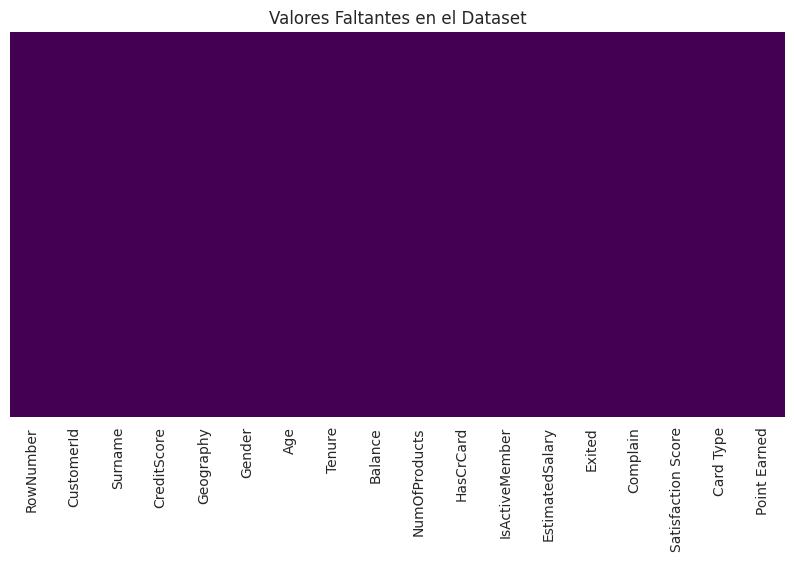


Duplicados:


,0
RowNumber,10000
CustomerId,10000
Surname,2932
CreditScore,460
Geography,3
Gender,2
Age,70
Tenure,11
Balance,6382
NumOfProducts,4


In [ ]:
# Identificar valores faltantes
print("\nValores faltantes por columna:")
print(df.isnull().sum())

# Visualización de valores faltantes
plt.figure(figsize=(10, 5))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Valores Faltantes en el Dataset")
plt.show()

# Duplicados
print("\nDuplicados:")
df.nunique()

**Observaciones**

- **RowNumber y CustomerId** : Presentan 10.000 valores únicos, uno por cada fila, infieriendo que cada registro del dataset es único. Esto es ideal para el análisis y el modelado.

- **Identificación de variables categóricas**: El valor de (2) en **Gender - Has Card - Complain - Is Active Member** indican que son **categóricas dicotómicas** |  La presencia valores únicos en columnas como **Geography (3) - Card Type (4)** indican que son **variables categóricas nominales** | La presencia de valores únicos en **NumOfProducts (4)- Satisfaction Score (5)** indican que son **variables categóricas ordinales**| **Surname** completa las 9 variables categóricas.


## 2.3. Análisis univariado: Distribución de las variables numéricas

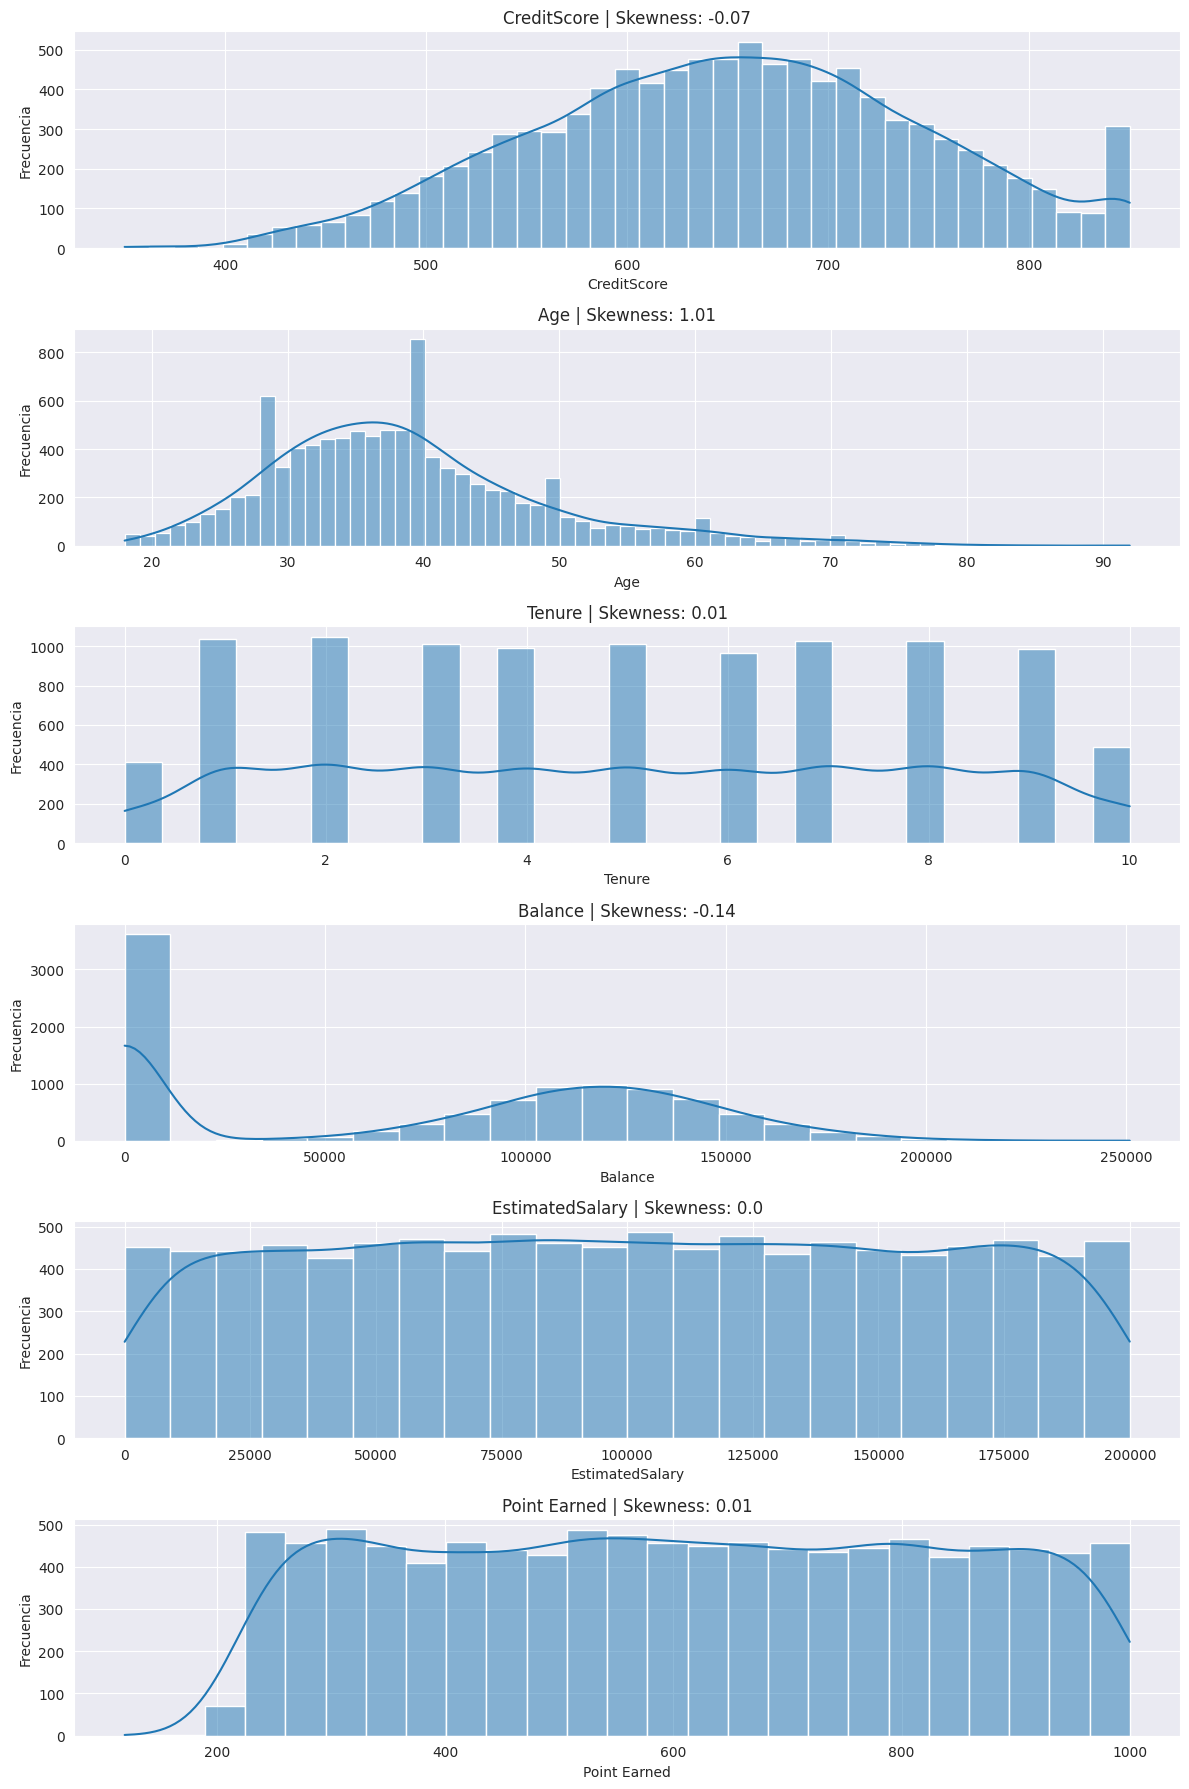

In [ ]:
# Variables numéricas de interés
numerical_columns_to_plot = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned']

# Estilo de gráfico
sns.set_style("darkgrid")

# Tamaño de la figura
plt.figure(figsize=(12, len(numerical_columns_to_plot) * 3))

# Creacion de los histogramas
for idx, feature in enumerate(numerical_columns_to_plot, 1):
    plt.subplot(len(numerical_columns_to_plot), 1, idx)
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}")
    plt.xlabel(feature)
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()


**Resumen de Variables Numéricas Continuas**


- **Credit Score** presenta una tendencia normal, ligeramente sesgada a la izquierda
- **Age** presenta un sesgo a la derecha
- **Tenure - EstimatedSalary -  Point Earned**: Distribuciónes uniformes
- **Balance** presenta una cierta normalidad
- **Credit Score - Age - Balance** presentan datos atípicos en frecuencia


**Deducciones visuales**

- Sesgo de los Datos (**Credit Score - Age**): El sesgo en estas variables indica que la mayoría de los clientes tienen puntuaciones de crédito más altas **(550-750)** y edades entre **30 y 45 años**, lo cual puede ser un factor importante para el abandono. **(Los valores brindados son estimaciones)**

- El análisis de **Balance** es clave. La gran cantidad de **ceros** en Balance podría ser una variable predictiva muy fuerte.

- Distribución Uniforme (**Tenure - EstimatedSalary - Point Earned**): Esta uniformidad sugiere que estas variables no tienen un valor "típico". Todos los valores en el rango son igualmente probables, lo que podrían no tener implicaciones en cómo se relacionan con el abandono.


## 2.4. Análisis Bivariado:

- **Relación entre variables numéricas y categóricas con la variable objetivo (`Exited`)**

- **Relación entre variables numéricas**

### 2.4.1. Variable positiva (Exited) según variables categóricas tipo objeto

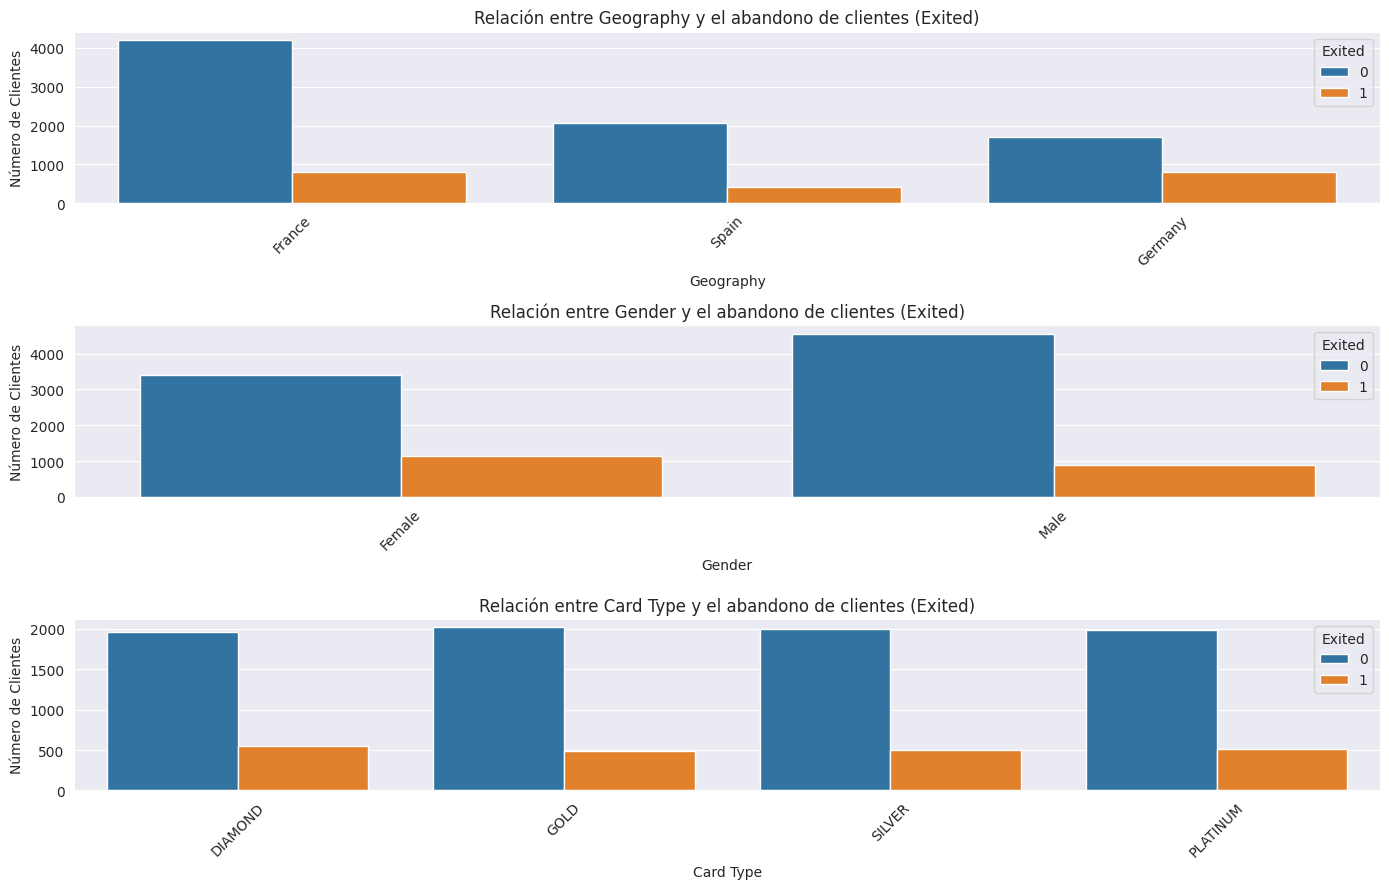

In [ ]:
# Variable objetivo
target = 'Exited'

# Seleccionar las columnas categóricas y eliminar 'Surname'
# df.select_dtypes(include="object").columns selecciona todas las columnas de tipo 'object'
# .drop('Surname') elimina la columna 'Surname' de esa selección
categorical_columns = df.select_dtypes(include="object").columns.drop('Surname')

# Tamaño de la figura para que todos los gráficos se vean bien
plt.figure(figsize=(14, len(categorical_columns) * 3))

# Gráfico de barras
for idx, feature in enumerate(categorical_columns, 1):
    plt.subplot(len(categorical_columns), 1, idx)
    sns.countplot(data=df, x=feature, hue=target)
    plt.title(f"Relación entre {feature} y el abandono de clientes ({target})")
    plt.xticks(rotation=45)
    plt.ylabel("Número de Clientes")

plt.tight_layout()
plt.show()

**Observaciones**


- Se elimino el **Apellido** por la baja predictividad
- En **proporción**, Francia fue el país mas fiel y España fue mas fiel que Alemania
- El **genero** femenino abandona más que el masculino
- El **Tipo de tarjeta** parece no inferir respecto al abandono
- No se consideraron Variables Categóricas codificadas:
**NumOfProducts - HasCrCard - IsActiveMember - Complain - Satisfaction Score**

**Geography - Gender parecen ser variables predictoras**


### 2.4.2. Variable positiva (Exited) según variables categóricas codificadas

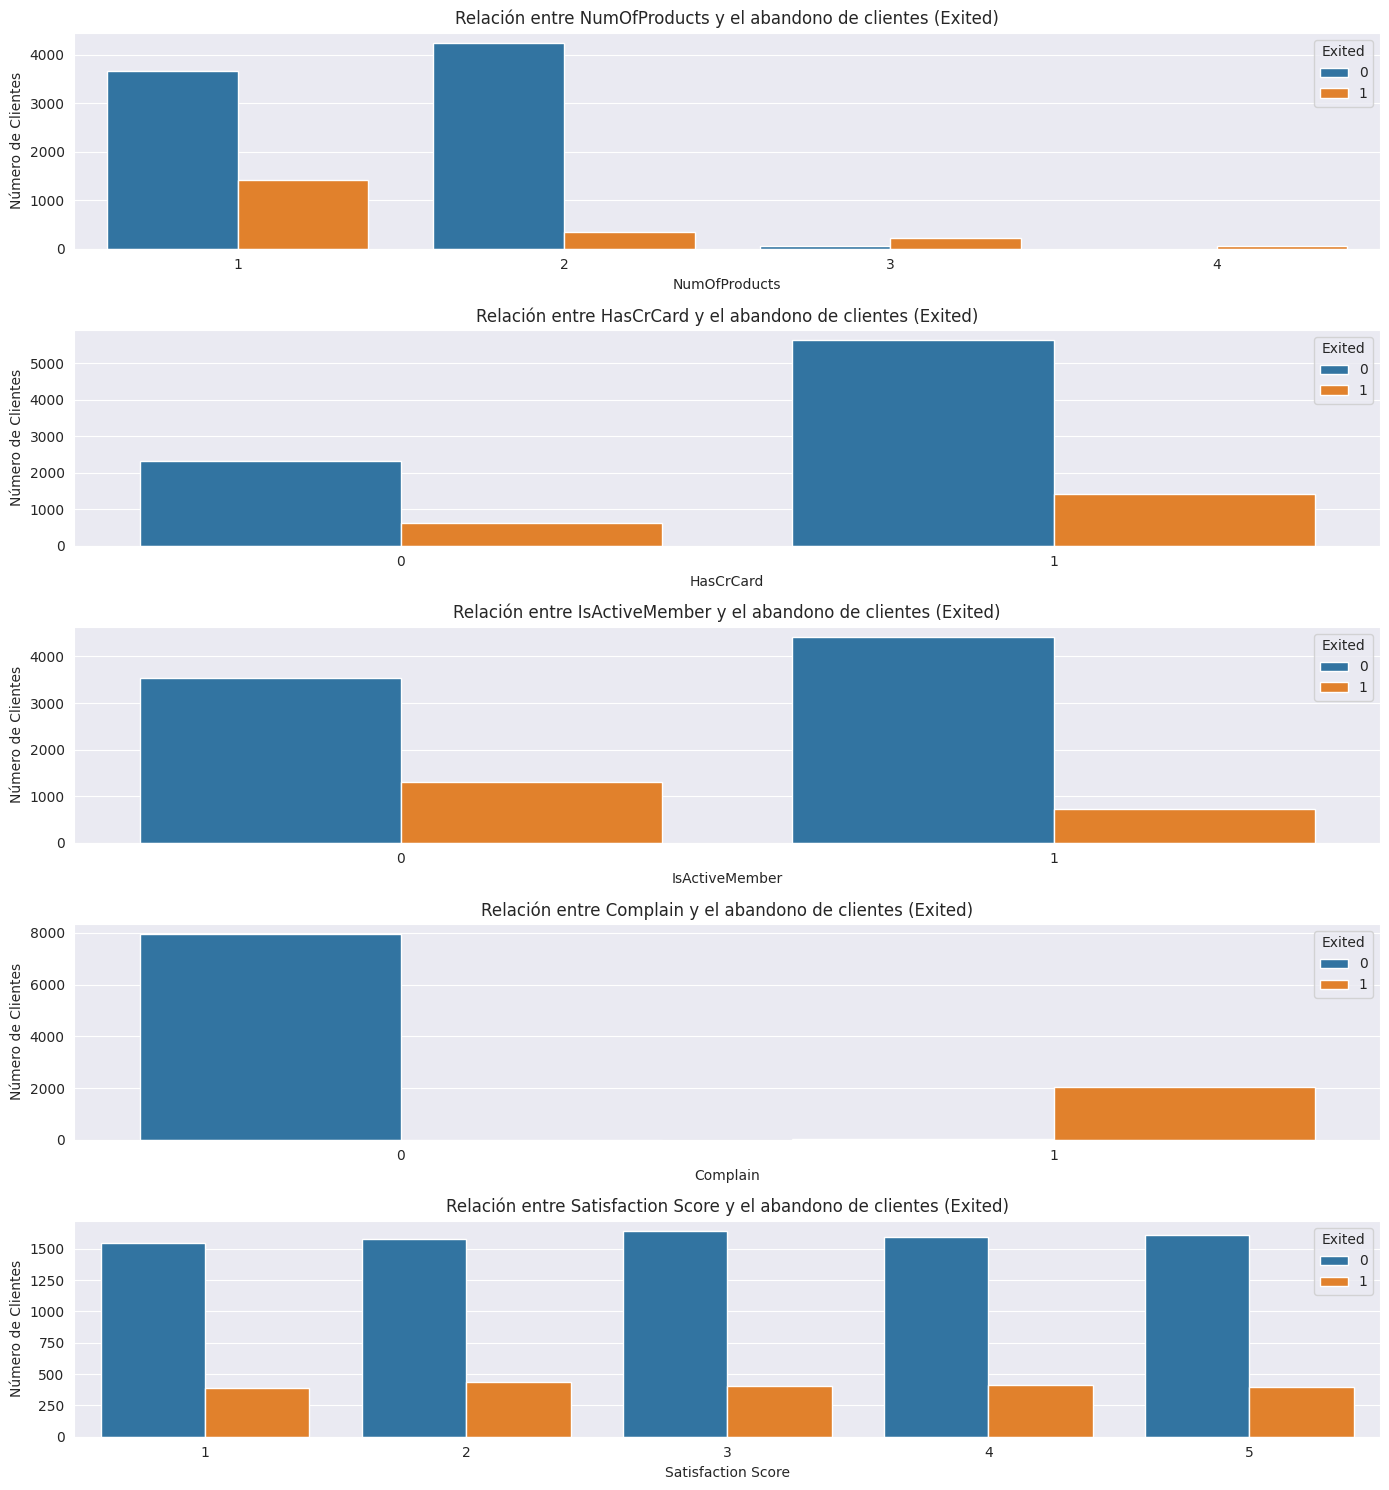

In [ ]:
# Variable Objetivo
target = 'Exited'

# Variables categóricas codificadas
encoded_categorical_columns = ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Complain', 'Satisfaction Score']

# Tamaño del gráfico
plt.figure(figsize=(14, len(encoded_categorical_columns) * 3))

# Iterar sobre las columnas para crear un gráfico de barras para cada una
for idx, feature in enumerate(encoded_categorical_columns, 1):
    plt.subplot(len(encoded_categorical_columns), 1, idx)
    sns.countplot(data=df, x=feature, hue=target)
    plt.title(f"Relación entre {feature} y el abandono de clientes ({target})")
    plt.xticks(rotation=0)  # No es necesario rotar, los nombres son cortos
    plt.ylabel("Número de Clientes")

plt.tight_layout()
plt.show()


**Observaciones**


- A medida que aumenta el **número de productos** adquiridos mediante el banco, el abandono tiende a disminuir, aunque a partir de tres productos se observa un leve repunte en la tasa de salida.
- De los que tenian tarjetas, la mayor cantidad **no ha abandonado**.
- De los que eran miembros activos, la mayor cantidad **no ha abandonado**.
- La **queja** tiene un gran papel en la permanencia o ausencia ( existe un desbalance)
- De acuerdo al **score de satisfacción**, no se evidencian diferencias significativas hacia el abandono.
- Se puede ver como la clasificación de estas **variables en categóricas codificadas** toma importancia en el código del **EDA**

**Se considera que Num of Product - Has Card - Is Active Member - Complain son variables predictoras**

# **Hasta el momento se puede decir que de las 8 variables categóricas que exploramos, 6 se consideran predictoras**

### 2.4.3. Variables numéricas según la clase positiva (Exited) y la clase negativa.

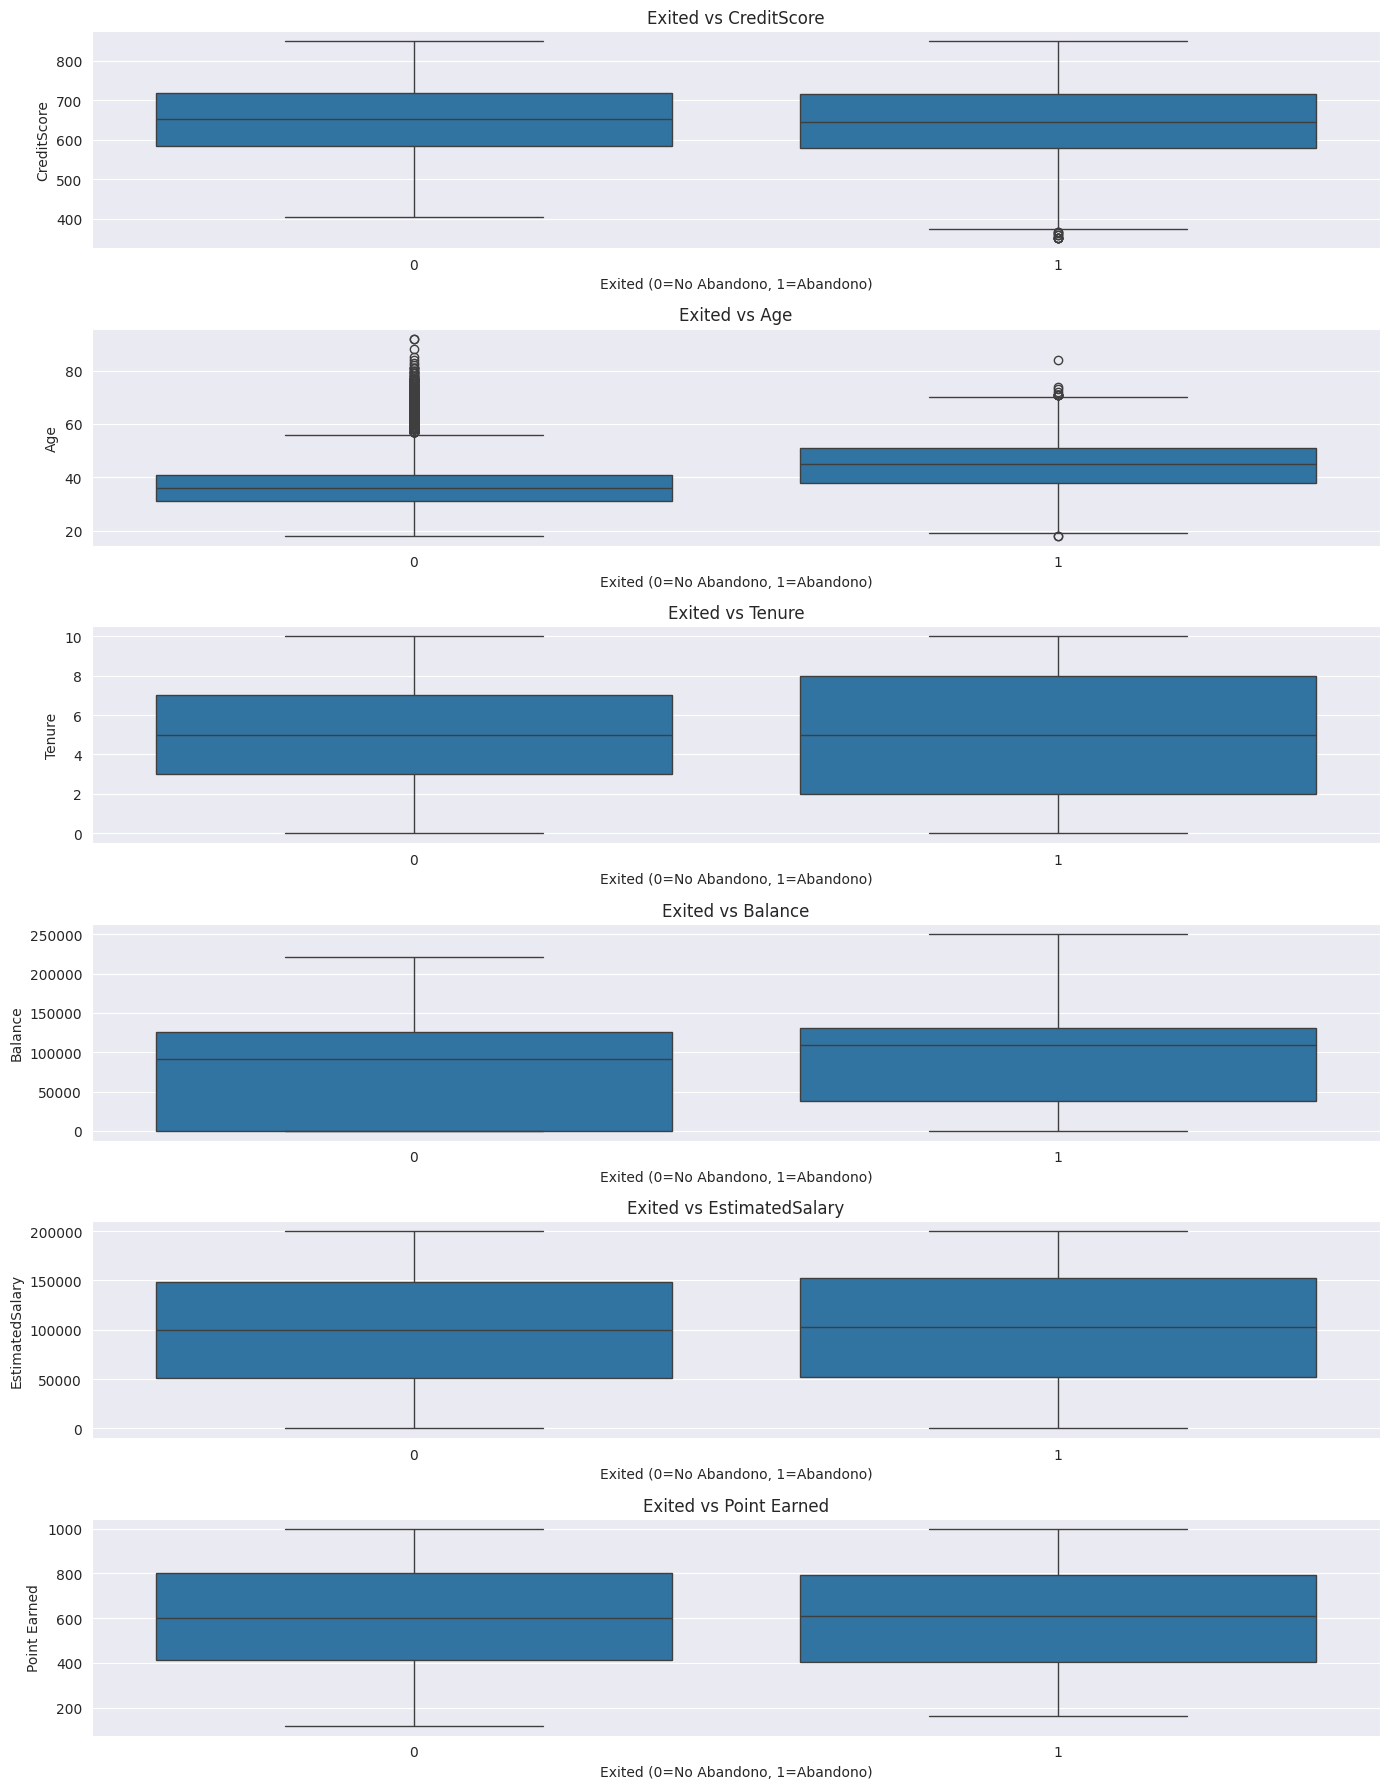

In [ ]:
# Definir la variable objetivo
target = 'Exited'

# Seleccionar solo las columnas numéricas que te interesan
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned']

# Configurar el tamaño del gráfico para una mejor visualización
# El número de filas se ajusta dinámicamente según la cantidad de columnas
plt.figure(figsize=(14, len(numerical_columns) * 3))

# Iterar sobre las columnas numéricas para crear un boxplot para cada una
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, idx)
    sns.boxplot(data=df, x=target, y=feature)
    plt.title(f"{target} vs {feature}")
    plt.xlabel("Exited (0=No Abandono, 1=Abandono)")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

**Resultados de cada variable sobre la target**

- **Cedit Score**: Distribución similar para abandono o no - Parece no ser predictora.
- **Age**: La mediana de la edad de los que abandonan es considerablemente mas alta: **variable clave** - Los clientes cercanos a la mediana edad parecen ser  mas propensos al abandono.
- Se observan algunos **outliers** en las gráficas anteriores, no siendo considerados errores de registros
- **Tenure**: Mediana similares en abandono o permanencia.
RI **(Rango intercuartilico)** distintos - no parece se muy predictora.
- **Balance**: La Clase que abandona posee una mediana mas alta - predictora - saldos mas altos parecen abandonar | Saltos en Cero toman una gran relevancia.
- **Estimated Salary y Point Earned**: RI y Mediana similares, no parecen ser predictoras.

Se presume una capacidad predictiva para **Age y Balance**.

# **En esta instancia se puede decir que de las 14 variables que exploramos 8 se han considerado predictoras | Variables para completar las 18: Row Number - Costumer ID - Surname : (no relevantes) + Exited (target)**

### 2.4.4. Dependencia de las variable categóricas con la variable objetivo (Exited)

In [ ]:
# Definir la función para calcular Cramér's V
def cramers_v(tabla):
    chi2 = chi2_contingency(tabla)[0]
    n = tabla.sum().sum()
    k = min(tabla.shape) - 1
    return np.sqrt(chi2 / (n * k))

# 1. Variable objetivo
target = 'Exited'

# 2. Selección de varibales
categorical_columns = [
    'Geography',
    'Gender',
    'Card Type',
    'NumOfProducts',
    'HasCrCard',
    'IsActiveMember',
    'Complain',
    'Satisfaction Score'
]

# 3. Calcular Cramér's V y almacenar los resultados
resultados = []
for col in categorical_columns:
    # Usar el DataFrame principal 'df' para asegurar la alineación
    tabla = pd.crosstab(df[col], df[target])
    coef = cramers_v(tabla)
    resultados.append([col, coef])

# 4. Crear DataFrame de resultados y ordenarlo
cramers_df = pd.DataFrame(resultados, columns=['Variable', "Cramers_V"])
cramers_df.sort_values(by="Cramers_V", ascending=False, inplace=True)

# 5. Mostrar la tabla de resultados
print("\nRelación entre variables categóricas y la variable objetivo (Exited):")
print(cramers_df)


Relación entre variables categóricas y la variable objetivo (Exited):
             Variable  Cramers_V
6            Complain   0.995385
3       NumOfProducts   0.387493
0           Geography   0.173386
5      IsActiveMember   0.156107
1              Gender   0.106017
2           Card Type   0.022479
7  Satisfaction Score   0.019501
4           HasCrCard   0.006704


**Observaciones**

- Se puede verificar que **Card Type y Satisfactión Score** han sido correctamente descartadas por su baja capacidad de predicción.
- **Has Card** no habia sido descartada, por lo que se evidencia gracias a Cramer´s, la posibilidad de prescindir de ella en el modelado.

- No se tuvo en cuenta **Surname**: Carece de **sentido de negocio**, ya que el apellido de una persona no guarda relación con el abandono.

### 2.4.5. Correlación entre variables numéricas para evitar la multicolinealidad en el modelo sensibles

La **Regresión Logística** es un modelo lineal que funciona estimando los coeficientes (pesos) para cada variable. Un coeficiente positivo indica que un aumento en el valor de esa variable está asociado con un aumento en la probabilidad de que la variable objetivo sea 1.

La **multicolinealidad** ocurre cuando dos o más variables predictoras en un modelo están altamente correlacionadas entre sí. En otras palabras, una variable puede predecir a otra, lo que dificulta al modelo diferenciar el efecto individual de cada una en la variable objetivo

A su vez, este paso muestra la existencia de relación entre **variables numéricas** con la variable objetivo.

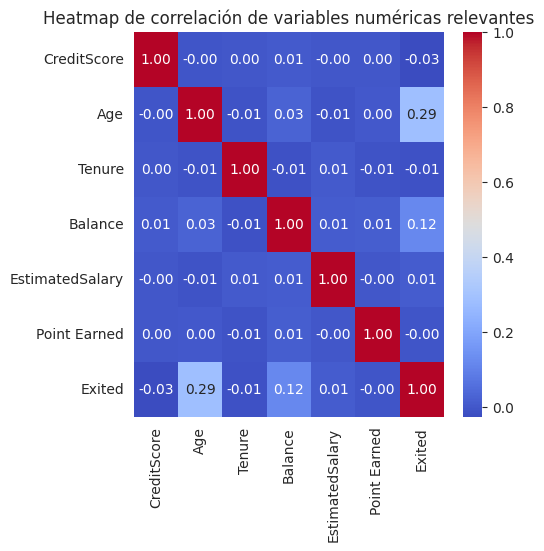

In [ ]:
# 1. Variables numéricas relevantes
relevant_numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned', 'Exited']

# 2. Data Frame nuevo
df_relevant_numerics = df[relevant_numerical_columns]

# 3. Matriz de correlación de Pearson
correlation_matrix = df_relevant_numerics.corr()

# 4. Heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap de correlación de variables numéricas relevantes")
plt.show()

**Observaciones**

Se puede observar que las únicas variables que presentan un grado de correlación con la variable de salida **Exited** son **Age y Balance**, correctamente exploradas con anterioridad.

A su vez, se verifica la **ausencia de multicolinealidad** entre las variables mencionadas.

# **Conclusiones del EDA**

## Las variables **Complain - Is Active Member - Age - Num of Products - Balance - Gender - Geography** se podrían considerar **Variables Predictoras**, mientras que **Has Card** parece no guardar relación con el abandono, de acuerdo con la prueba de Cramer´s

# **3. Preprocesamiento de Datos**

## Preparado de los datos para que puedan ser utilizados por los modelos de Machine Learning.

## 3.1. Eliminación de las variables irrelevantes

In [ ]:
# Lista de variables irrelevantes para eliminar
variables_irrelevantes = ['RowNumber', 'CustomerId', 'Surname']

# Eliminar las columnas del DataFrame de manera permanente
# La adición de errors='ignore' previene errores si la columna no existe
df.drop(columns=variables_irrelevantes, inplace=True, errors='ignore')

# 1. Contar el número total de variables que quedan
num_total_variables = df.shape[1]

# 2. Contar variables categóricas (object) y codificadas (int64, float64)
# Excluimos la variable objetivo 'Exited' del conteo
num_categoricas_object = df.select_dtypes(include=['object']).columns.size
num_numericas = df.select_dtypes(include=['int64', 'float64']).columns.size - 1

# 3. Imprimir el recuento
print("Columnas del DataFrame después de la eliminación:")
print(df.columns)
print("-" * 50)
print("Número de variables para el modelado:")
print(f"Total de variables: {num_total_variables}")
print(f"Variables categóricas (object): {num_categoricas_object}")
print(f"Variables numéricas y categóricas codificadas: {num_numericas}")

Columnas del DataFrame después de la eliminación:
Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Complain', 'Satisfaction Score', 'Card Type',
       'Point Earned'],
      dtype='object')
--------------------------------------------------
Número de variables para el modelado:
Total de variables: 15
Variables categóricas (object): 3
Variables numéricas y categóricas codificadas: 11


## 3.2. Feature Engineering
El valor de 0 en la variable **Balance** es atípico por la cantidad de observaciones, no por ser un valor extremo aislado. Representa un estado particular del cliente (**sin saldo**), que puede ser un fuerte predictor de abandono.

Crear una variable binaria (**Balance_Zero**) permite a los modelos de machine learning capturar esta información de manera más directa y efectiva. En lugar de interpretar el 0 de Balance como simplemente un valor numérico, el modelo ahora puede usar una característica categórica que dice **"el cliente no tiene saldo"**.

In [ ]:
# Crear una nueva columna binaria llamada 'Balance_Zero'
# Esta columna tendrá un 1 si el saldo es 0 y un 0 en cualquier otro caso
df['Balance_Zero'] = (df['Balance'] == 0).astype(int)

# Opcional: mostrar las primeras filas del DataFrame para verificar el cambio
print("Primeras 5 filas del DataFrame con la nueva columna 'Balance_Zero':")
print(df.head())

Primeras 5 filas del DataFrame con la nueva columna 'Balance_Zero':
   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  Complain  \
0          1               1        101348.88       1         1   
1          0               1        112542.58       0         1   
2          1               0        113931.57       1         1   
3          0               0         93826.63       0         0   
4          1               1         79084.10       0         0   

   Satisfaction Score Card Type  Point Earned  Balance_Zero  
0               

# **4. Modelado y Evaluación**

## **Modelos de Machine Learning**
## **Regresión Logística |k-NN | Random Forest | Light GBM | XGBoost**

Para el entrenamiento de los modelos propuestos **Regresión Logística, k-NN, Random Forest, LightGBM y XGBoost** se ha establecido el **AUC (Área bajo la Curva ROC)** como la **métrica** principal de comparación. Esta elección se basa en tres fundamentos claves:

**Insensibilidad al Desbalance:** A diferencia de la precisión, que puede ser engañosamente alta en datasets desequilibrados, el AUC es una métrica insensible al desbalance de clases, lo cual es crítico para nuestro problema de predicción de abandono.

**Capacidad de Discriminación:** El AUC evalúa la capacidad del modelo para distinguir entre clases, independientemente del umbral de clasificación elegido. Esto nos permite comparar modelos de manera justa.

**Superación del Bajo Recall:** El recall para la clase minoritaria (clientes que abandonan) tiende a ser bajo en datasets desequilibrados. El AUC ofrece una visión más completa del rendimiento del modelo sin verse penalizado por este factor.


**Evaluación y Optimización del Modelo**

**Validación Cruzada**

Para asegurar que nuestros resultados sean confiables y que los modelos tengan una sólida **capacidad de generalización**, se ha optado por la validación cruzada como el método principal de entrenamiento y evaluación. Aunque una división simple en entrenamiento y prueba es útil, su rendimiento puede depender de una partición aleatoria "afortunada" o "desafortunada" de los datos.

En contraste, la validación cruzada es una técnica más **robusta**. Se divide el conjunto de entrenamiento en múltiples subconjuntos **(k-folds)**, y el modelo se entrena y valida **k** veces, utilizando cada k-fold como conjunto de prueba una vez. Este proceso exhaustivo no solo nos proporciona una estimación de rendimiento más **confiable y estable**, sino que también reduce el riesgo de **sobreajuste**, garantizando que el modelo funcionará de manera efectiva con datos nuevos y no vistos.


## 4.1. Separación en datos de entrenamiento y prueba

Para garantizar una evaluación justa y robusta de los modelos, la metodología de preprocesamiento se ha diseñado para evitar el **filtrado de datos** (data leakage) y optimizar el rendimiento de cada algoritmo.

**División de los Datos (train_test_split)**: La primera y única división de los datos en conjuntos de entrenamiento y prueba se realizará al inicio de la etapa de modelado. Esto garantiza que el conjunto de prueba permanezca completamente aislado, sirviendo como una fuente de datos "no vistos" para una evaluación final y honesta del rendimiento de cada modelo.



In [ ]:
# El df es el DataFrame luego de la limpieza y el feature engineering
# Se definen las variables predictoras (X) y la variable objetivo (y)
X = df.drop('Exited', axis=1)
y = df['Exited']

# Realizar la división de datos
# test_size=0.2 asigna el 20% de los datos al conjunto de prueba
# random_state=42 asegura que los resultados sean reproducibles
# stratify=y mantiene la misma proporción de la variable 'Exited' en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Imprimir las formas de los conjuntos para verificar la división
print("Forma de los conjuntos de datos después de la división única:")
print(f"X_train: {X_train.shape}")
print(X_train.head())
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

Forma de los conjuntos de datos después de la división única:
X_train: (8000, 15)
      CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
4791          709     Spain    Male   35       2       0.00              2   
8881          744    France    Male   29       1   43504.42              1   
6166          773    France    Male   64       2  145578.28              1   
4473          646   Germany  Female   29       4  105957.44              1   
854           675    France  Female   57       8       0.00              2   

      HasCrCard  IsActiveMember  EstimatedSalary  Complain  \
4791          1               0        104982.39         0   
8881          1               1        119327.75         0   
6166          0               1        186172.85         0   
4473          1               0         15470.91         0   
854           0               1         95463.29         0   

      Satisfaction Score Card Type  Point Earned  Balance_Zero  
4791       

**Consideraciones en los modelos**

**Integración de Pipelines**: Se implementarán pipelines personalizados para cada grupo de modelos. Estos son cruciales porque encadenan el preprocesamiento, el balanceo de clases y el entrenamiento del modelo en un solo objeto.

**Codificación y Estandarización**: Dentro de cada pipeline, se aplicará la codificación de variables categóricas **(One-Hot Encoding)** y la estandarización de variables numéricas **(StandardScaler)** solo a los datos de entrenamiento y en modelos que lo requieran. Esta práctica evita que los transformadores aprendan de la distribución de los datos de prueba, previniendo así el data leakage.

**Balanceo de Clases**: La técnica de balanceo de datos **(SMOTE)** también se integrará dentro del pipeline. Esto es fundamental para garantizar que el sobremuestreo se aplique de manera segura solo en el conjunto de entrenamiento de cada iteración, evitando el sobreajuste y la contaminación de los datos de prueba.

## 4.2. Modelos de Machine Learning Clásicos:

Dado que la **Regresión Logística** calcula los pesos de las variables predictoras, el rango de las variables debe ser estandarizado, para que no haya un desbalance.

Debido a que **KNN** es un método basado en el cálculo de distancia, también su rango debe de ser estandarizado.


- Se establece un **Standar Scaler** para Regresión Logística y KNN
- Se aplica en ambos modelos **One-Hot Econding** para codificar variables categóricas tipo objeto





## 4.2.1 Regresión logística + SMOTE + Validación cruzada según el AUC.

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Resultados de la Búsqueda en la Cuadrícula:
Mejores hiperparámetros encontrados: {'classifier__C': 1, 'classifier__penalty': 'l1'}
Mejor AUC promedio en validación cruzada: 0.9995


Evaluación del Modelo de Regresión Logística en el Conjunto de Prueba:
AUC-ROC en test: 0.9988

Informe de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



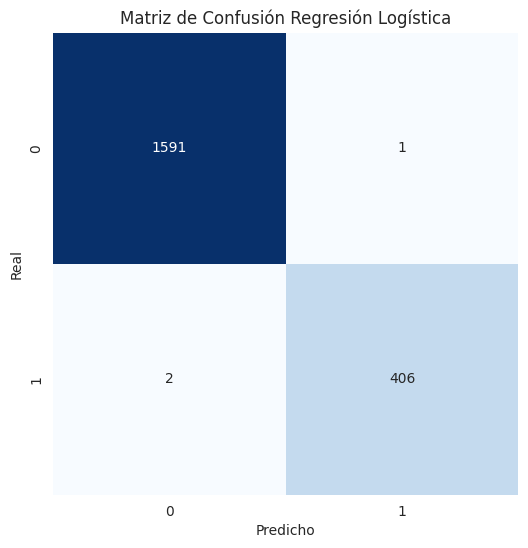

In [ ]:


# 1. Definir las variables para el preprocesamiento

# Variables numéricas continuas a escalar
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned']
# Variables categóricas tipo 'object' a codificar
categorical_features = ['Geography', 'Gender', 'Card Type']
# Variables categóricas codificadas numéricamente que no se modifican
passthrough_features = ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Complain', 'Satisfaction Score', 'Balance_Zero']


# 2. Preprocesador para modelos lineales (MLC)

preprocessor_MLC = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)


# 3. Pipeline para Regresión Logística con SMOTE

# Usamos ImbPipeline para que SMOTE se integre correctamente con GridSearchCV
pipeline_LR = ImbPipeline([
    ('preprocessor', preprocessor_MLC),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=1000))
])


# 4. Búsqueda de Hiperparámetros con GridSearchCV


# Definir los hiperparámetros a buscar
param_grid_LR = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}

# Definir la validación cruzada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crear el objeto GridSearchCV
grid_search_LR = GridSearchCV(
    estimator=pipeline_LR,
    param_grid=param_grid_LR,
    scoring='roc_auc',  # Usamos AUC-ROC como métrica de evaluación principal
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search_LR.fit(X_train, y_train)


# 5. Evaluación del Mejor Modelo


# Extraer el mejor modelo
best_model_LR = grid_search_LR.best_estimator_

# Predecir las probabilidades en el conjunto de prueba
y_pred_prob_LR = best_model_LR.predict_proba(X_test)[:, 1]

# Predecir las clases en el conjunto de prueba
y_pred_class_LR = best_model_LR.predict(X_test)

# Mostrar los resultados
print("\n" + "="*50 + "\n")
print("Resultados de la Búsqueda en la Cuadrícula:")
print(f"Mejores hiperparámetros encontrados: {grid_search_LR.best_params_}")
print(f"Mejor AUC promedio en validación cruzada: {grid_search_LR.best_score_:.4f}")
print("\n" + "="*50 + "\n")
print("Evaluación del Modelo de Regresión Logística en el Conjunto de Prueba:")
print(f"AUC-ROC en test: {roc_auc_score(y_test, y_pred_prob_LR):.4f}")
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred_class_LR))

# Visualizar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_class_LR)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión Regresión Logística')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

## 4.2.2 K-NN + SMOTE + Validación cruzada según el AUC.

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Resultados de la Búsqueda en la Cuadrícula para KNN:
Mejores hiperparámetros encontrados: {'classifier__n_neighbors': 11, 'classifier__weights': 'distance'}
Mejor AUC promedio en validación cruzada: 0.9620


Evaluación del Modelo KNN en el Conjunto de Prueba:
AUC-ROC en test: 0.9698

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      1592
           1       0.72      0.93      0.81       408

    accuracy                           0.91      2000
   macro avg       0.85      0.92      0.88      2000
weighted avg       0.93      0.91      0.91      2000



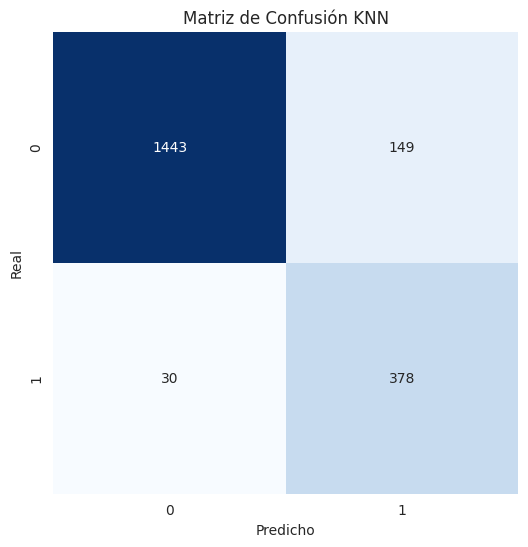

In [ ]:

# 1. Definir las variables para el preprocesamiento
# Usamos las mismas listas de variables, ya que el preprocesamiento es similar
# para KNN y Regresión Logística
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned']
categorical_features = ['Geography', 'Gender', 'Card Type']
passthrough_features = ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Complain', 'Satisfaction Score', 'Balance_Zero']


# 2. Preprocesador para modelos lineales y basados en distancia

preprocessor_MLC = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)


# 3. Pipeline para KNN con SMOTE

pipeline_KNN = ImbPipeline([
    ('preprocessor', preprocessor_MLC),
    ('smote', SMOTE(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

# 4. Búsqueda de Hiperparámetros con GridSearchCV

# Definir los hiperparámetros a buscar para KNN
param_grid_KNN = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance']
}

# Definir la validación cruzada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crear el objeto GridSearchCV
grid_search_KNN = GridSearchCV(
    estimator=pipeline_KNN,
    param_grid=param_grid_KNN,
    scoring='roc_auc',  # Usamos AUC-ROC como métrica de evaluación
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

# Ajustar GridSearchCV a los datos de entrenamiento
# Asegúrate de que X_train y y_train estén disponibles en el entorno
grid_search_KNN.fit(X_train, y_train)




# Extraer el mejor modelo
best_model_KNN = grid_search_KNN.best_estimator_

# Predecir las probabilidades en el conjunto de prueba
y_pred_prob_KNN = best_model_KNN.predict_proba(X_test)[:, 1]

# Predecir las clases en el conjunto de prueba
y_pred_class_KNN = best_model_KNN.predict(X_test)

# Mostrar los resultados
print("\n" + "="*50 + "\n")
print("Resultados de la Búsqueda en la Cuadrícula para KNN:")
print(f"Mejores hiperparámetros encontrados: {grid_search_KNN.best_params_}")
print(f"Mejor AUC promedio en validación cruzada: {grid_search_KNN.best_score_:.4f}")
print("\n" + "="*50 + "\n")
print("Evaluación del Modelo KNN en el Conjunto de Prueba:")
print(f"AUC-ROC en test: {roc_auc_score(y_test, y_pred_prob_KNN):.4f}")
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred_class_KNN))

# Visualizar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_class_KNN)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión KNN')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

## 4.3. Modelos de Machine Learning Avanzados:

En cuanto a los modelos **Light GBM, XGBoost y Random Forest** se destacan los siguientes tratamientos:

- Los modelos no necesitan del escalado de variables.
- Se aplica  **One-Hot Econding** para codificar variables categóricas tipo objeto

## 4.3.1 Light GBM + SMOTE + Validación cruzada según el AUC.

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Number of positive: 6370, number of negative: 6370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4856
[LightGBM] [Info] Number of data points in the train set: 12740, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

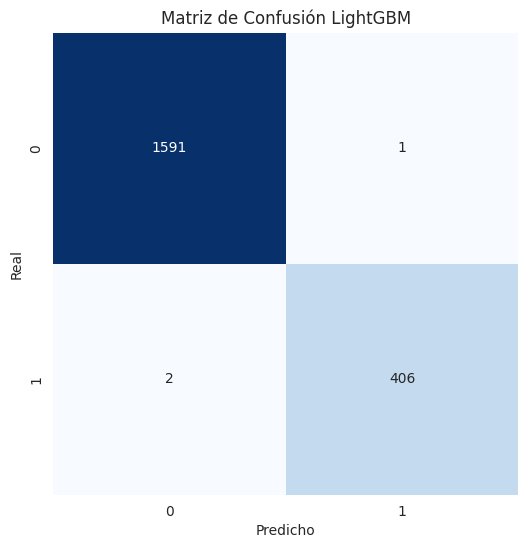

In [ ]:

# 1. Definir las variables para el preprocesamiento

# La misma clasificación de variables
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned']
categorical_features = ['Geography', 'Gender', 'Card Type']
passthrough_features = ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Complain', 'Satisfaction Score', 'Balance_Zero']



# 2. Preprocesador para modelos de árboles (MLA)

# LightGBM no necesita escalado. Unicamente se codifican las variables categóricas.
preprocessor_MLA = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)



# 3. Pipeline para LightGBM con SMOTE

pipeline_LGBM = ImbPipeline([
    ('preprocessor', preprocessor_MLA),
    ('smote', SMOTE(random_state=42)),
    ('classifier', lgb.LGBMClassifier(random_state=42))
])



# 4. Búsqueda de Hiperparámetros con GridSearchCV

# Definir los hiperparámetros a buscar para LightGBM
param_grid_LGBM = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__num_leaves': [31, 50, 70]
}

# Definir la validación cruzada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crear el objeto GridSearchCV
grid_search_LGBM = GridSearchCV(
    estimator=pipeline_LGBM,
    param_grid=param_grid_LGBM,
    scoring='roc_auc',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search_LGBM.fit(X_train, y_train)



# 5. Evaluación del Mejor Modelo

# Extraer el mejor modelo
best_model_LGBM = grid_search_LGBM.best_estimator_

# Predecir las probabilidades en el conjunto de prueba
y_pred_prob_LGBM = best_model_LGBM.predict_proba(X_test)[:, 1]

# Predecir las clases en el conjunto de prueba
y_pred_class_LGBM = best_model_LGBM.predict(X_test)

# Mostrar los resultados
print("\n" + "="*50 + "\n")
print("Resultados de la Búsqueda en la Cuadrícula para LightGBM:")
print(f"Mejores hiperparámetros encontrados: {grid_search_LGBM.best_params_}")
print(f"Mejor AUC promedio en validación cruzada: {grid_search_LGBM.best_score_:.4f}")
print("\n" + "="*50 + "\n")
print("Evaluación del Modelo LightGBM en el Conjunto de Prueba:")
print(f"AUC-ROC en test: {roc_auc_score(y_test, y_pred_prob_LGBM):.4f}")
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred_class_LGBM))

# Visualizar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_class_LGBM)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión LightGBM')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

## 4.3.2 XGBoost + SMOTE + Validación cruzada según el AUC.

Fitting 5 folds for each of 108 candidates, totalling 540 fits


Resultados de la Búsqueda en la Cuadrícula para XGBoost:
Mejores hiperparámetros encontrados: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Mejor AUC promedio en validación cruzada: 0.9996


Evaluación del Modelo XGBoost en el Conjunto de Prueba:
AUC-ROC en test: 0.9995

Informe de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



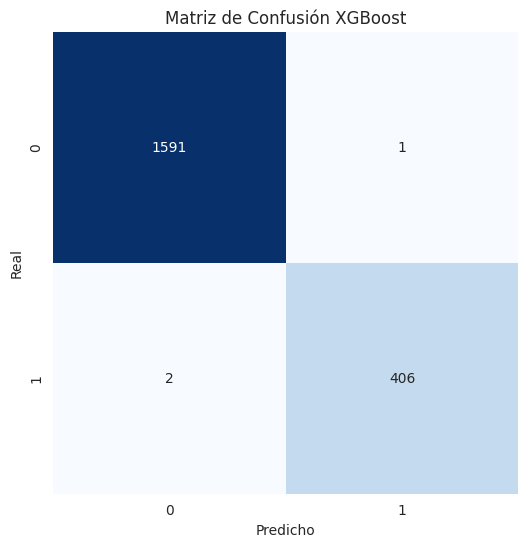

In [ ]:
# 1. Definir las variables para el preprocesamiento

# La misma clasificación de variables
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned']
categorical_features = ['Geography', 'Gender', 'Card Type']
passthrough_features = ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Complain', 'Satisfaction Score', 'Balance_Zero']

# 2. Preprocesador para modelos de árboles (MLA)

# XGBoost no necesita escalado. Únicamente se codifican las variables categóricas.
preprocessor_MLA = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# 3. Pipeline para XGBoost con SMOTE
from xgboost import XGBClassifier

pipeline_XGB = ImbPipeline([
    ('preprocessor', preprocessor_MLA),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        random_state=42,
        use_label_encoder=False,   # evita warnings de versiones antiguas
        eval_metric='logloss'      # métrica recomendada para evitar warning
    ))
])

# 4. Búsqueda de Hiperparámetros con GridSearchCV

# Definir los hiperparámetros a buscar para XGBoost
param_grid_XGB = {
    'classifier__n_estimators': [100, 200, 400],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    # Opcionales (regularización):
    # 'classifier__reg_lambda': [1.0, 2.0, 5.0],
    # 'classifier__min_child_weight': [1, 3, 5]
}

# Definir la validación cruzada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crear el objeto GridSearchCV
grid_search_XGB = GridSearchCV(
    estimator=pipeline_XGB,
    param_grid=param_grid_XGB,
    scoring='roc_auc',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search_XGB.fit(X_train, y_train)

# 5. Evaluación del Mejor Modelo

# Extraer el mejor modelo
best_model_XGB = grid_search_XGB.best_estimator_

# Predecir las probabilidades en el conjunto de prueba
y_pred_prob_XGB = best_model_XGB.predict_proba(X_test)[:, 1]

# Predecir las clases en el conjunto de prueba
y_pred_class_XGB = best_model_XGB.predict(X_test)

# Mostrar los resultados
print("\n" + "="*50 + "\n")
print("Resultados de la Búsqueda en la Cuadrícula para XGBoost:")
print(f"Mejores hiperparámetros encontrados: {grid_search_XGB.best_params_}")
print(f"Mejor AUC promedio en validación cruzada: {grid_search_XGB.best_score_:.4f}")
print("\n" + "="*50 + "\n")
print("Evaluación del Modelo XGBoost en el Conjunto de Prueba:")
print(f"AUC-ROC en test: {roc_auc_score(y_test, y_pred_prob_XGB):.4f}")
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred_class_XGB))

# Visualizar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_class_XGB)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión XGBoost')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

## 4.3.3 Random Forest + SMOTE + Validación cruzada según el AUC.

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Resultados de la Búsqueda en la Cuadrícula para Random Forest:
Mejores hiperparámetros encontrados: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Mejor AUC promedio en validación cruzada: 0.9996


Evaluación del Modelo Random Forest en el Conjunto de Prueba:
AUC-ROC en test: 0.9983

Informe de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



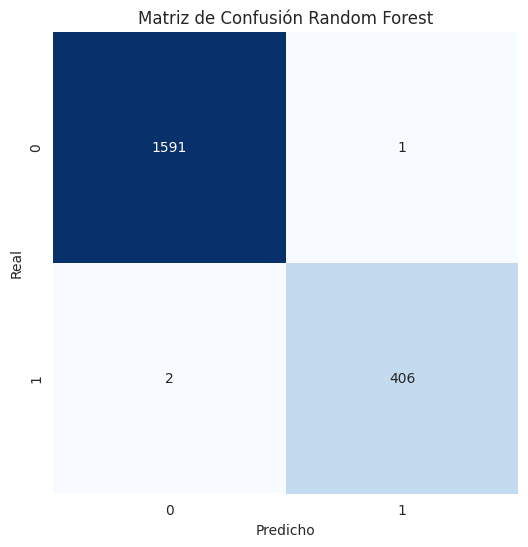

In [ ]:

# 1. Definir las variables para el preprocesamiento

# La misma clasificación de variables
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned']
categorical_features = ['Geography', 'Gender', 'Card Type']
passthrough_features = ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Complain', 'Satisfaction Score', 'Balance_Zero']



# 2. Preprocesador para modelos de árboles (MLA)

# Random Forest no necesita escalado. Unicamente se codifican las variables categóricas.
preprocessor_MLA = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)



# 3. Pipeline para Random Forest con SMOTE

pipeline_RF = ImbPipeline([
    ('preprocessor', preprocessor_MLA),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])



# 4. Búsqueda de Hiperparámetros con GridSearchCV

# Definir los hiperparámetros a buscar para Random Forest
param_grid_RF = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10]
}

# Definir la validación cruzada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crear el objeto GridSearchCV
grid_search_RF = GridSearchCV(
    estimator=pipeline_RF,
    param_grid=param_grid_RF,
    scoring='roc_auc',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

# Ajustar GridSearchCV a los datos de entrenamiento
# Asegúrate de que X_train y y_train estén disponibles en el entorno
grid_search_RF.fit(X_train, y_train)


# 5. Evaluación del Mejor Modelo

# Extraer el mejor modelo
best_model_RF = grid_search_RF.best_estimator_

# Predecir las probabilidades en el conjunto de prueba
y_pred_prob_RF = best_model_RF.predict_proba(X_test)[:, 1]

# Predecir las clases en el conjunto de prueba
y_pred_class_RF = best_model_RF.predict(X_test)

# Mostrar los resultados
print("\n" + "="*50 + "\n")
print("Resultados de la Búsqueda en la Cuadrícula para Random Forest:")
print(f"Mejores hiperparámetros encontrados: {grid_search_RF.best_params_}")
print(f"Mejor AUC promedio en validación cruzada: {grid_search_RF.best_score_:.4f}")
print("\n" + "="*50 + "\n")
print("Evaluación del Modelo Random Forest en el Conjunto de Prueba:")
print(f"AUC-ROC en test: {roc_auc_score(y_test, y_pred_prob_RF):.4f}")
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred_class_RF))

# Visualizar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_class_RF)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión Random Forest')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

## 4.4. Tabla de resultados

In [ ]:
# Datos de los modelos
data = {
    'Modelo': ['Regresión Logística', 'KNN', 'LightGBM','XGBoost', 'Random Forest'],
    'AUC-ROC': [0.9988, 0.9698, 0.9980,0.9995, 0.9983]
}

# Crear el DataFrame
df_resultados = pd.DataFrame(data)

# Ordenar el DataFrame de forma descendente por la métrica AUC-ROC
# Para ordenar de mejor a peor, se usa ascending=False
df_resultados = df_resultados.sort_values(by='AUC-ROC', ascending=False)

# Mostrar la tabla
print("Tabla de Comparación de Modelos (ordenada por AUC-ROC):")
print(df_resultados)

Tabla de Comparación de Modelos (ordenada por AUC-ROC):
                Modelo  AUC-ROC
3              XGBoost   0.9995
0  Regresión Logística   0.9988
4        Random Forest   0.9983
2             LightGBM   0.9980
1                  KNN   0.9698


#  **5. Interpretabilidad de los Modelos**

En esta sección se mostrará el aporte de cada variable a la predicción mediante el uso **SHAP Values**. Se pretende asi buscar saber cuan responsable es cada variable sobre la predcción del abandono.

- El **Bar Plot** refleja la importancia relativa de las variables ante el abandono.
- El **Summary** refleja el impacto de la variable en la clase positiva

**Machine Learning Avanzados**

## 5.1. XGBoost SHAP Values

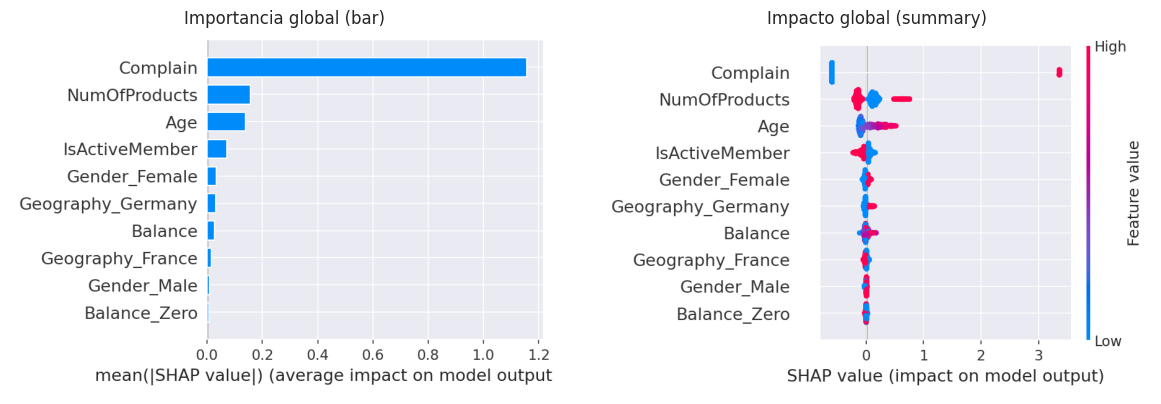

In [ ]:


# 0) Tomar el mejor pipeline entrenado
pipe = best_model_XGB  # pipeline ganador

# 1) Transformar TRAIN y TEST con el preprocesador
# (Usamos TRAIN como background para el explainer: evita shape mismatches)
X_train_pre = pipe.named_steps['preprocessor'].transform(X_train)
X_test_pre  = pipe.named_steps['preprocessor'].transform(X_test)

# Convertir a array denso float64 si es necesario
def _to_dense_float(X):
    if hasattr(X, "toarray"):
        X = X.toarray()
    return X.astype(np.float64)

X_train_pre = _to_dense_float(X_train_pre)
X_test_pre  = _to_dense_float(X_test_pre)

# 2) Nombres de variables (limpios)
try:
    feature_names = pipe.named_steps['preprocessor'].get_feature_names_out()
    feature_names = [n.replace("remainder__", "").replace("cat__", "") for n in feature_names]
except Exception:
    feature_names = None

#3) Explainer SHAP
model = pipe.named_steps['classifier']
# Para modelos de árboles (RF/LGBM/XGB), el Explainer detecta TreeExplainer internamente
explainer = shap.Explainer(model, X_train_pre)     # <<--- background = TRAIN ya preprocesado
shap_expl = explainer(X_test_pre)                  # Devuelve un shap.Explanation

# Extraer matriz de valores (maneja binario/multiclase de forma segura)
# - Binario: shap_expl.values -> (n_samples, n_features)
# - Multiclase: (n_samples, n_features, n_classes) -> tomamos la clase positiva (1) si existe
values = shap_expl.values
if values.ndim == 3:
    # elegir clase positiva si está (1); si no, tomar la última como fallback
    if model.classes_.shape[0] > 1:
        import numpy as np
        if 1 in model.classes_:
            pos_idx = int(np.where(model.classes_ == 1)[0][0])
        else:
            pos_idx = -1
    else:
        pos_idx = -1
    values = values[:, :, pos_idx]

#4) Guardar gráficos por separado con tamaño controlado
bar_path = "shap_bar_rf.png"
sum_path = "shap_summary_rf.png"

# Bar plot
plt.figure()
shap.summary_plot(
    values,                 # matriz (n_samples, n_features)
    X_test_pre,             # datos ya preprocesados
    feature_names=feature_names,
    plot_type="bar",
    show=False,
    max_display=10,
    plot_size=(6, 4)        # ancho, alto en pulgadas
)
plt.tight_layout()
plt.savefig(bar_path, dpi=150, bbox_inches="tight")
plt.close()

# Summary plot
plt.figure()
shap.summary_plot(
    values,
    X_test_pre,
    feature_names=feature_names,
    show=False,
    max_display=10,
    plot_size=(6, 4)
)
plt.tight_layout()
plt.savefig(sum_path, dpi=150, bbox_inches="tight")
plt.close()

# 5) Componer lado a lado en una sola figura
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(plt.imread(bar_path))
axes[0].set_title("Importancia global (bar)")
axes[0].axis("off")

axes[1].imshow(plt.imread(sum_path))
axes[1].set_title("Impacto global (summary)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

**Observaciones**:

**Bar Plot**
- La variable **Complain** domina fuertemente en importancia (1,18 aprox), seguido por **Num of Products** (0,16 aprox) , **Age** (0,15 aprox) e **Is Active Member**(0,09 aprox)

**Impacto y dirección**
- **Complain** tiene un impacto muy alto: Valores muy altos **(en rojo)** impulsan la salida al abandono **(3,2 aprox)** y valores muy bajos **(en azul)** impulsan a permanecer en el banco **(clase negativa)** en menor medida **(-0.5 aprox)**

**Bajo impacto**
- **Num of Products**: El efecto es menos estable (algunos clientes con muchos productos se quedan, otros se van → nube más dispersa)
- **Age**: Los clientes de mediana y mayor edad tienden a irse , los de baja edad tienden a quedarse
- **Is Active Member**: Los miembros con baja actividad suelen irse.
- **Geography, Balance y Gender** tienen menos pesos y menor influencia

## 5.2. Random Forest SHAP Values

 99%|===================| 3963/4000 [01:45<00:00]       

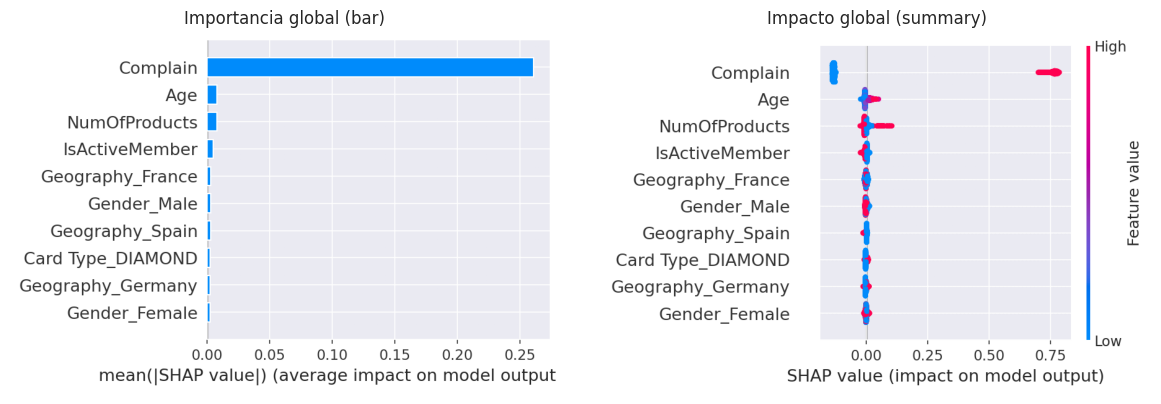

In [ ]:
#0) Tomar el mejor pipeline entrenado
pipe = best_model_RF  # <- tu pipeline ganador (RF)

#1) Transformar TRAIN y TEST con el preprocesador
# (Usamos TRAIN como background para el explainer: evita shape mismatches)
X_train_pre = pipe.named_steps['preprocessor'].transform(X_train)
X_test_pre  = pipe.named_steps['preprocessor'].transform(X_test)

# Convertir a array denso float64 si es necesario
def _to_dense_float(X):
    if hasattr(X, "toarray"):
        X = X.toarray()
    return X.astype(np.float64)

X_train_pre = _to_dense_float(X_train_pre)
X_test_pre  = _to_dense_float(X_test_pre)

# 2) Nombres de variables (limpios)
try:
    feature_names = pipe.named_steps['preprocessor'].get_feature_names_out()
    feature_names = [n.replace("remainder__", "").replace("cat__", "") for n in feature_names]
except Exception:
    feature_names = None

#3) Explainer SHAP
model = pipe.named_steps['classifier']
# Para modelos de árboles (RF/LGBM/XGB), el Explainer detecta TreeExplainer internamente
explainer = shap.Explainer(model, X_train_pre)     # <<--- background = TRAIN ya preprocesado
shap_expl = explainer(X_test_pre)                  # Devuelve un shap.Explanation

# Extraer matriz de valores (maneja binario/multiclase de forma segura)
# - Binario: shap_expl.values -> (n_samples, n_features)
# - Multiclase: (n_samples, n_features, n_classes) -> tomamos la clase positiva (1) si existe
values = shap_expl.values
if values.ndim == 3:
    # elegir clase positiva si está (1); si no, tomar la última como fallback
    if model.classes_.shape[0] > 1:
        import numpy as np
        if 1 in model.classes_:
            pos_idx = int(np.where(model.classes_ == 1)[0][0])
        else:
            pos_idx = -1
    else:
        pos_idx = -1
    values = values[:, :, pos_idx]

#4) Guardar gráficos por separado con tamaño controlado
bar_path = "shap_bar_rf.png"
sum_path = "shap_summary_rf.png"

# -- Bar plot
plt.figure()
shap.summary_plot(
    values,                 # matriz (n_samples, n_features)
    X_test_pre,             # datos ya preprocesados
    feature_names=feature_names,
    plot_type="bar",
    show=False,
    max_display=10,
    plot_size=(6, 4)        # ancho, alto en pulgadas
)
plt.tight_layout()
plt.savefig(bar_path, dpi=150, bbox_inches="tight")
plt.close()

# -- Summary plot
plt.figure()
shap.summary_plot(
    values,
    X_test_pre,
    feature_names=feature_names,
    show=False,
    max_display=10,
    plot_size=(6, 4)
)
plt.tight_layout()
plt.savefig(sum_path, dpi=150, bbox_inches="tight")
plt.close()

#5) Componer lado a lado en una sola figura
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(plt.imread(bar_path))
axes[0].set_title("Importancia global (bar)")
axes[0].axis("off")

axes[1].imshow(plt.imread(sum_path))
axes[1].set_title("Impacto global (summary)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

**Observaciones**

**Bar plot:**
- Otra vez **Complain** domina con gran diferencia.
- Variables como  **(Age, NumOfProducts, IsActiveMember, etc)** aparecen pero con valores relativos mas bajos.

**Impacto y dirección:**

- El impacto de **Complain** es prácticamente determinante: cuando el cliente se queja (alto valor), empuja la predicción fuertemente hacia la clase positiva.
- **Age y NumOfProducts** destacan sus aportes a la clase positiva, pero con un impacto menor

**Otras variables apenas dispersan alrededor de cero → el modelo casi decide todo en función de Complain.**

## 5.3. Light GBM SHAP Values

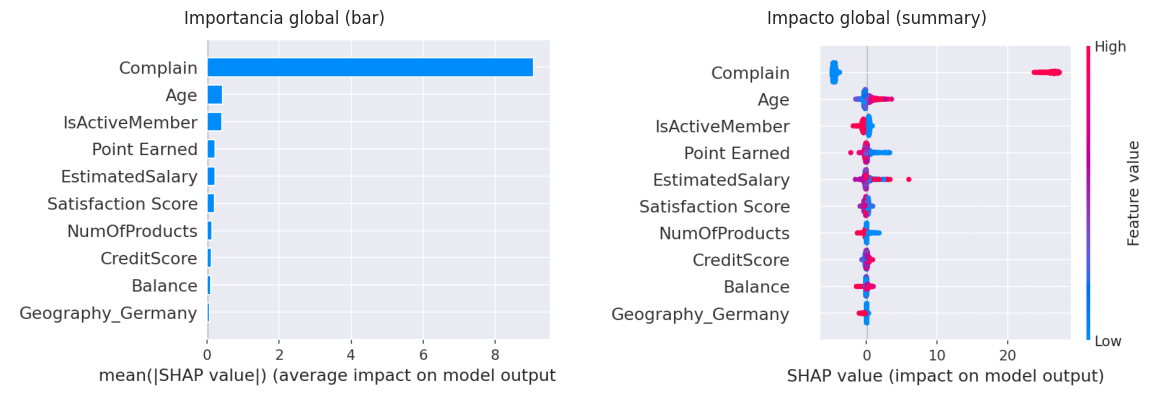

In [ ]:

# 0) Tomar el mejor pipeline entrenado
pipe = best_model_LGBM  # <- tu pipeline ganador (LGBM).

#  1) Transformar TRAIN y TEST con el preprocesador
# (Usamos TRAIN como background para el explainer: evita shape mismatches)
X_train_pre = pipe.named_steps['preprocessor'].transform(X_train)
X_test_pre  = pipe.named_steps['preprocessor'].transform(X_test)

# Convertir a array denso float64 si es necesario
def _to_dense_float(X):
    if hasattr(X, "toarray"):
        X = X.toarray()
    return X.astype(np.float64)

X_train_pre = _to_dense_float(X_train_pre)
X_test_pre  = _to_dense_float(X_test_pre)

#2) Nombres de variables (limpios)
try:
    feature_names = pipe.named_steps['preprocessor'].get_feature_names_out()
    feature_names = [n.replace("remainder__", "").replace("cat__", "") for n in feature_names]
except Exception:
    feature_names = None

# 3) Explainer SHAP
model = pipe.named_steps['classifier']

explainer = shap.Explainer(model, X_train_pre)     # <<--- background = TRAIN ya preprocesado
shap_expl = explainer(X_test_pre)                  # Devuelve un shap.Explanation

# Extraer matriz de valores (maneja binario/multiclase de forma segura)
# - Binario: shap_expl.values -> (n_samples, n_features)
# - Multiclase: (n_samples, n_features, n_classes) -> tomamos la clase positiva (1) si existe
values = shap_expl.values
if values.ndim == 3:
    # elegir clase positiva si está (1); si no, tomar la última como fallback
    if model.classes_.shape[0] > 1:
        import numpy as np
        if 1 in model.classes_:
            pos_idx = int(np.where(model.classes_ == 1)[0][0])
        else:
            pos_idx = -1
    else:
        pos_idx = -1
    values = values[:, :, pos_idx]

# 4) Guardar gráficos por separado con tamaño controlado
bar_path = "shap_bar_rf.png"
sum_path = "shap_summary_rf.png"

# -- Bar plot --
plt.figure()
shap.summary_plot(
    values,                 # matriz (n_samples, n_features)
    X_test_pre,             # datos ya preprocesados
    feature_names=feature_names,
    plot_type="bar",
    show=False,
    max_display=10,
    plot_size=(6, 4)        # ancho, alto en pulgadas
)
plt.tight_layout()
plt.savefig(bar_path, dpi=150, bbox_inches="tight")
plt.close()

# -- Summary plot --
plt.figure()
shap.summary_plot(
    values,
    X_test_pre,
    feature_names=feature_names,
    show=False,
    max_display=10,
    plot_size=(6, 4)
)
plt.tight_layout()
plt.savefig(sum_path, dpi=150, bbox_inches="tight")
plt.close()

#  5) Componer lado a lado en una sola figura
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(plt.imread(bar_path))
axes[0].set_title("Importancia global (bar)")
axes[0].axis("off")

axes[1].imshow(plt.imread(sum_path))
axes[1].set_title("Impacto global (summary)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

**Observaciones**

**Bar plot:**

- También resalta **Complain** como primer variable de importancia ante el abandono
- Se aprecian variables como **Age, Is Active Member, Point Earned, Estimated Salary y demás** pero con una baja importancia relativa .

**Impacto y dirección:**

- **Complain** sigue siendo la más influyente, pero con mayor impacto en el abandono (25) que en XGBoost(3.2) y Random Forest(0.75).
- Los clientes de mediana y mayor edad tienden a abandonar.
- Los clientes inactivos tienden a abandonar
- **Point Earned y Estimated Salary** toman valor en el impacto

**Se observa una cierta dispersión en la decisión**

**Machine Learning Clásicos**

In [ ]:
def prepare_X_and_names(pipe, X):
    """Transforma X con el preprocesador del pipeline y devuelve datos densos + nombres limpios."""
    X_pre = pipe.named_steps['preprocessor'].transform(X)
    if hasattr(X_pre, "toarray"):
        X_pre = X_pre.toarray()
    X_pre = X_pre.astype(np.float64)
    try:
        names = pipe.named_steps['preprocessor'].get_feature_names_out()
        names = [n.replace("remainder__", "")
                   .replace("cat__", "")
                   .replace("num__", "")   # 🔹 Nuevo: elimina el prefijo num__
                 for n in names]
    except:
        names = None
    return X_pre, names

def plot_shap_side_by_side(values, X_pre, feature_names, prefix="model", max_display=10):
    """Genera bar + summary en PNGs chicos y los compone lado a lado."""
    bar_path = f"shap_bar_{prefix}.png"
    sum_path = f"shap_summary_{prefix}.png"

    # Bar
    plt.figure()
    shap.summary_plot(values, X_pre, feature_names=feature_names,
                      plot_type="bar", show=False, max_display=max_display, plot_size=(6,4))
    plt.tight_layout(); plt.savefig(bar_path, dpi=150, bbox_inches="tight"); plt.close()

    # Summary
    plt.figure()
    shap.summary_plot(values, X_pre, feature_names=feature_names,
                      show=False, max_display=max_display, plot_size=(6,4))
    plt.tight_layout(); plt.savefig(sum_path, dpi=150, bbox_inches="tight"); plt.close()

    # Componer
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    axes[0].imshow(plt.imread(bar_path)); axes[0].set_title("Importancia global (bar)"); axes[0].axis("off")
    axes[1].imshow(plt.imread(sum_path)); axes[1].set_title("Impacto global (summary)"); axes[1].axis("off")
    plt.tight_layout(); plt.show()

## 5.4. Regresión Logística SHAP Values

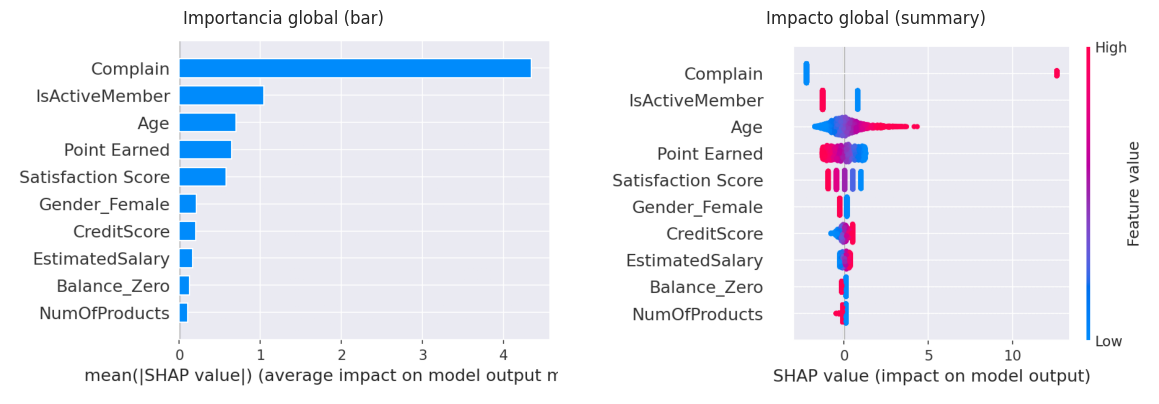

In [ ]:


#  1) Elegir pipeline ganador
pipe = best_model_LR

#  2) Preparar TRAIN y TEST preprocesados + nombres
X_train_pre, _           = prepare_X_and_names(pipe, X_train)   # background
X_test_pre, feature_names = prepare_X_and_names(pipe, X_test)

# 3) Explainer (lineal) y valores SHAP
model = pipe.named_steps['classifier']
explainer = shap.LinearExplainer(model, X_train_pre)  # background = train preprocesado
shap_values = explainer.shap_values(X_test_pre)       # matriz (n_samples, n_features)

# 4) Graficar (bar + summary) lado a lado
plot_shap_side_by_side(shap_values, X_test_pre, feature_names, prefix="logistic", max_display=10)

**Observaciones**

**Bar plot:**

- **Complain** otra vez lidera, le siguen **IsActiveMember,Age, Point Earned y Satisfaction Score**
- **Num of Products** no fue tomada como variable de gran importancia en relación con las anteriormente mencionadas.


**Impacto y dirección:**

- La variable **Complain** tiene mayor impacto en la salida, seguida de **Is active Member, Age,  Point Earned y Satisfaction Score**.
- Se observa como al **no** ser un miembro activo **Is Active Member = Azul** , el cliente se va.
- Se observa como los clientes de **mayor edad = Rojo** suelen abandonar.
- Se observa como los clientes con menor **puntajes ganados = Azul** (en el uso de la tarjeta) abandonan
- Se observa como los puntajes **bajos de satisfacción = Azul** tienden a abandonar.
- Se observa que el **Genero femenino** no suele abandonar
- Se observa que **salarios y scores crediticios** altos tienden a abandonar
- Se observa que el **balance en cero y muchas unidades compradas con el banco** no suelen abandonar.

**La contribución es más lineal: valores altos/bajos afectan consistentemente hacia arriba o abajo, sin tanta no linealidad como en árboles.**

## 5.5. KNN SHAP Values

  0%|          | 0/2000 [00:00<?, ?it/s]

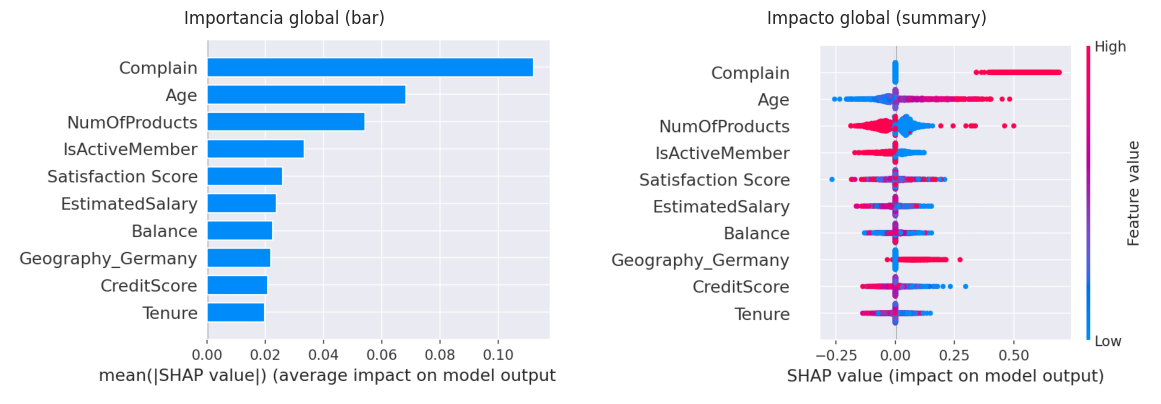

In [ ]:


# 0) Elegir pipeline
pipe = best_model_KNN

# 1) Preparar TRAIN/TEST preprocesados + nombres limpios
X_train_pre, _            = prepare_X_and_names(pipe, X_train)
X_test_pre, feature_names = prepare_X_and_names(pipe,  X_test)

# 2) Background resumido con kmeans (rápido/estable)
#    Podés ajustar K (30/50/100) según tiempo vs. precisión
background = shap.kmeans(X_train_pre, 15)

# 3) Función de predicción de prob. para la clase positiva
model = pipe.named_steps['classifier']
f_pos = lambda X: model.predict_proba(X)[:, 1]

# 4) KernelExplainer y cálculo de SHAP values
explainer = shap.KernelExplainer(f_pos, background)
# nsamples controla tiempo/precisión (100 va bien; subí si podés)
shap_values = explainer.shap_values(X_test_pre, nsamples=100)  # (n_samples, n_features)

# 5) Graficar bar + summary lado a lado con tu helper
plot_shap_side_by_side(shap_values, X_test_pre, feature_names, prefix="knn", max_display=10)

**Observaciones**

**Bar plot:**

- **Complain** vuelve a ser la más importante, pero ahora acompañada de cerca por **Age, NumOfProducts, IsActiveMember, Satisfaction Score** en mayor medida
- La importancia relativa se ve mas **atenuada** para todas las variables

**El KNN reparte la importancia entre más variables**.

**Impacto y dirección**

- Se observa **dispersión** en muchas variables, no solo en una.

- Aunque **Complain** sigue arriba, el modelo también usa activamente otras dimensiones para diferenciar los casos.

**La escala de los SHAP values es más reducida (impactos más acotados en comparación con árboles).**

## **Conclusiones de la sección**

El análisis de **SHAP Values** permitió comprender de manera detallada cómo cada variable impacta en la predicción de abandono de clientes, aportando interpretabilidad al desempeño de los modelos.

De forma consistente, en todos los algoritmos evaluados se observó que la variable **Complain** es el predictor más determinante del churn. En modelos de árboles como **XGBoost, LightGBM y Random Forest**, su efecto domina casi por completo, mientras que en **Regresión Logística y KNN** emergen otras variables con peso considerable.

Entre estas, destacan:

**Age**: los clientes de mayor edad tienden a presentar mayor riesgo de abandono.

**IsActiveMember**: La membresía activa se confirma como un factor protector frente al churn.

**NumOfProducts**: En general , a mayor cantidad de productos contratados se reduce la probabilidad de salida.

**Satisfaction Score y Point Earned**: variables de engagement y fidelización que, si bien no se destacaron en el EDA bivariado, adquieren relevancia en el análisis multivariado.

**Variables financieras (Balance, Estimated Salary, Credit Score)**: muestran impactos más moderados pero consistentes, contribuyendo al entendimiento del perfil del cliente que abandona.

En conclusión, el uso de **SHAP Values** no solo validó los hallazgos principales del **EDA** y de la **Regresión Logística**, sino que también reveló relaciones más complejas, permitiendo diferenciar entre predictores dominantes y variables de soporte. Así, se confirma que la queja es el principal disparador del churn, pero que factores de engagement, edad, satisfacción y fidelización también influyen en la permanencia de los clientes.

#  **6. Selección del modelo y análisis de los resultados del EDA**

## 6.1. Modelo Seleccionado

Cabe destacar que los valores de **AUC** obtenidos (≈0,99) son excepcionalmente altos en comparación con lo que suele observarse en problemas de churn reales, donde resultados entre 0,75 y 0,90 ya se consideran satisfactorios. Esto sugiere que el dataset de Kaggle utilizado podría contener patrones muy marcados o variables con fuerte poder discriminatorio, visto con anterioridad en **SHAP values**, lo que facilita la predicción. Si bien la validación cruzada contribuye a reducir el riesgo de sobreajuste, será fundamental validar el modelo con datos reales de una institución bancaria para confirmar la robustez de estos resultados.

De acuerdo al **AUC** de cada uno de los modelos, se puede concluir que la **Regresión Logística** es el modelo mas **Simple y Robusto** para esta ocasión.

Esta elección también se fundamenta en que los **modelos de arboles**: **XGBoost,Light GBM y Random Forest** se apoyan exclusivamente en la variable **Complain**, mientras que el modelo de **Regresión Logística** reparte mejor los pesos de cada variable.

Este criterio **toma valor** en la vida cotidiana, ya que la elección de este modelo disminuye el **riesgo** del proyecto si la variable **Complain** falta o cambia en el futuro.

Asi, por **simplicidad y robustez**, el modelo mas acorde a seleccionarse es la **Regresión Logística**

## 6.2. Análisis de la Regresión Logística y confirmación de los hallazgos del EDA





En esta sección, se presenta la validación de los hallazgos del análisis exploratorio de datos **(EDA)** a través del modelado predictivo. A su vez, se demuestra cómo la Regresión Logística, con su **capacidad de análisis multivariado**, no solo confirmó la precisión de nuestras hipótesis iniciales, sino que también descubrió relaciones y dependencias más sutiles y complejas que no eran evidentes en un análisis superficial.

Para ello, se evaluará la efectividad del modelo basándonos en dos pilares fundamentales:

**Análisis de Coeficientes:** Se mostrará el peso asignado por el modelo a cada variable, confirmando la importancia de nuestros hallazgos iniciales y revelando el impacto de otras características.

**Validación de la Linealidad:** Se demostrará visualmente la dependencia lineal entre el logaritmo de las probabilidades (log-odds) de abandono y las variables predictoras clave, validando la suposición central de la regresión logística y explicando su excepcional rendimiento.

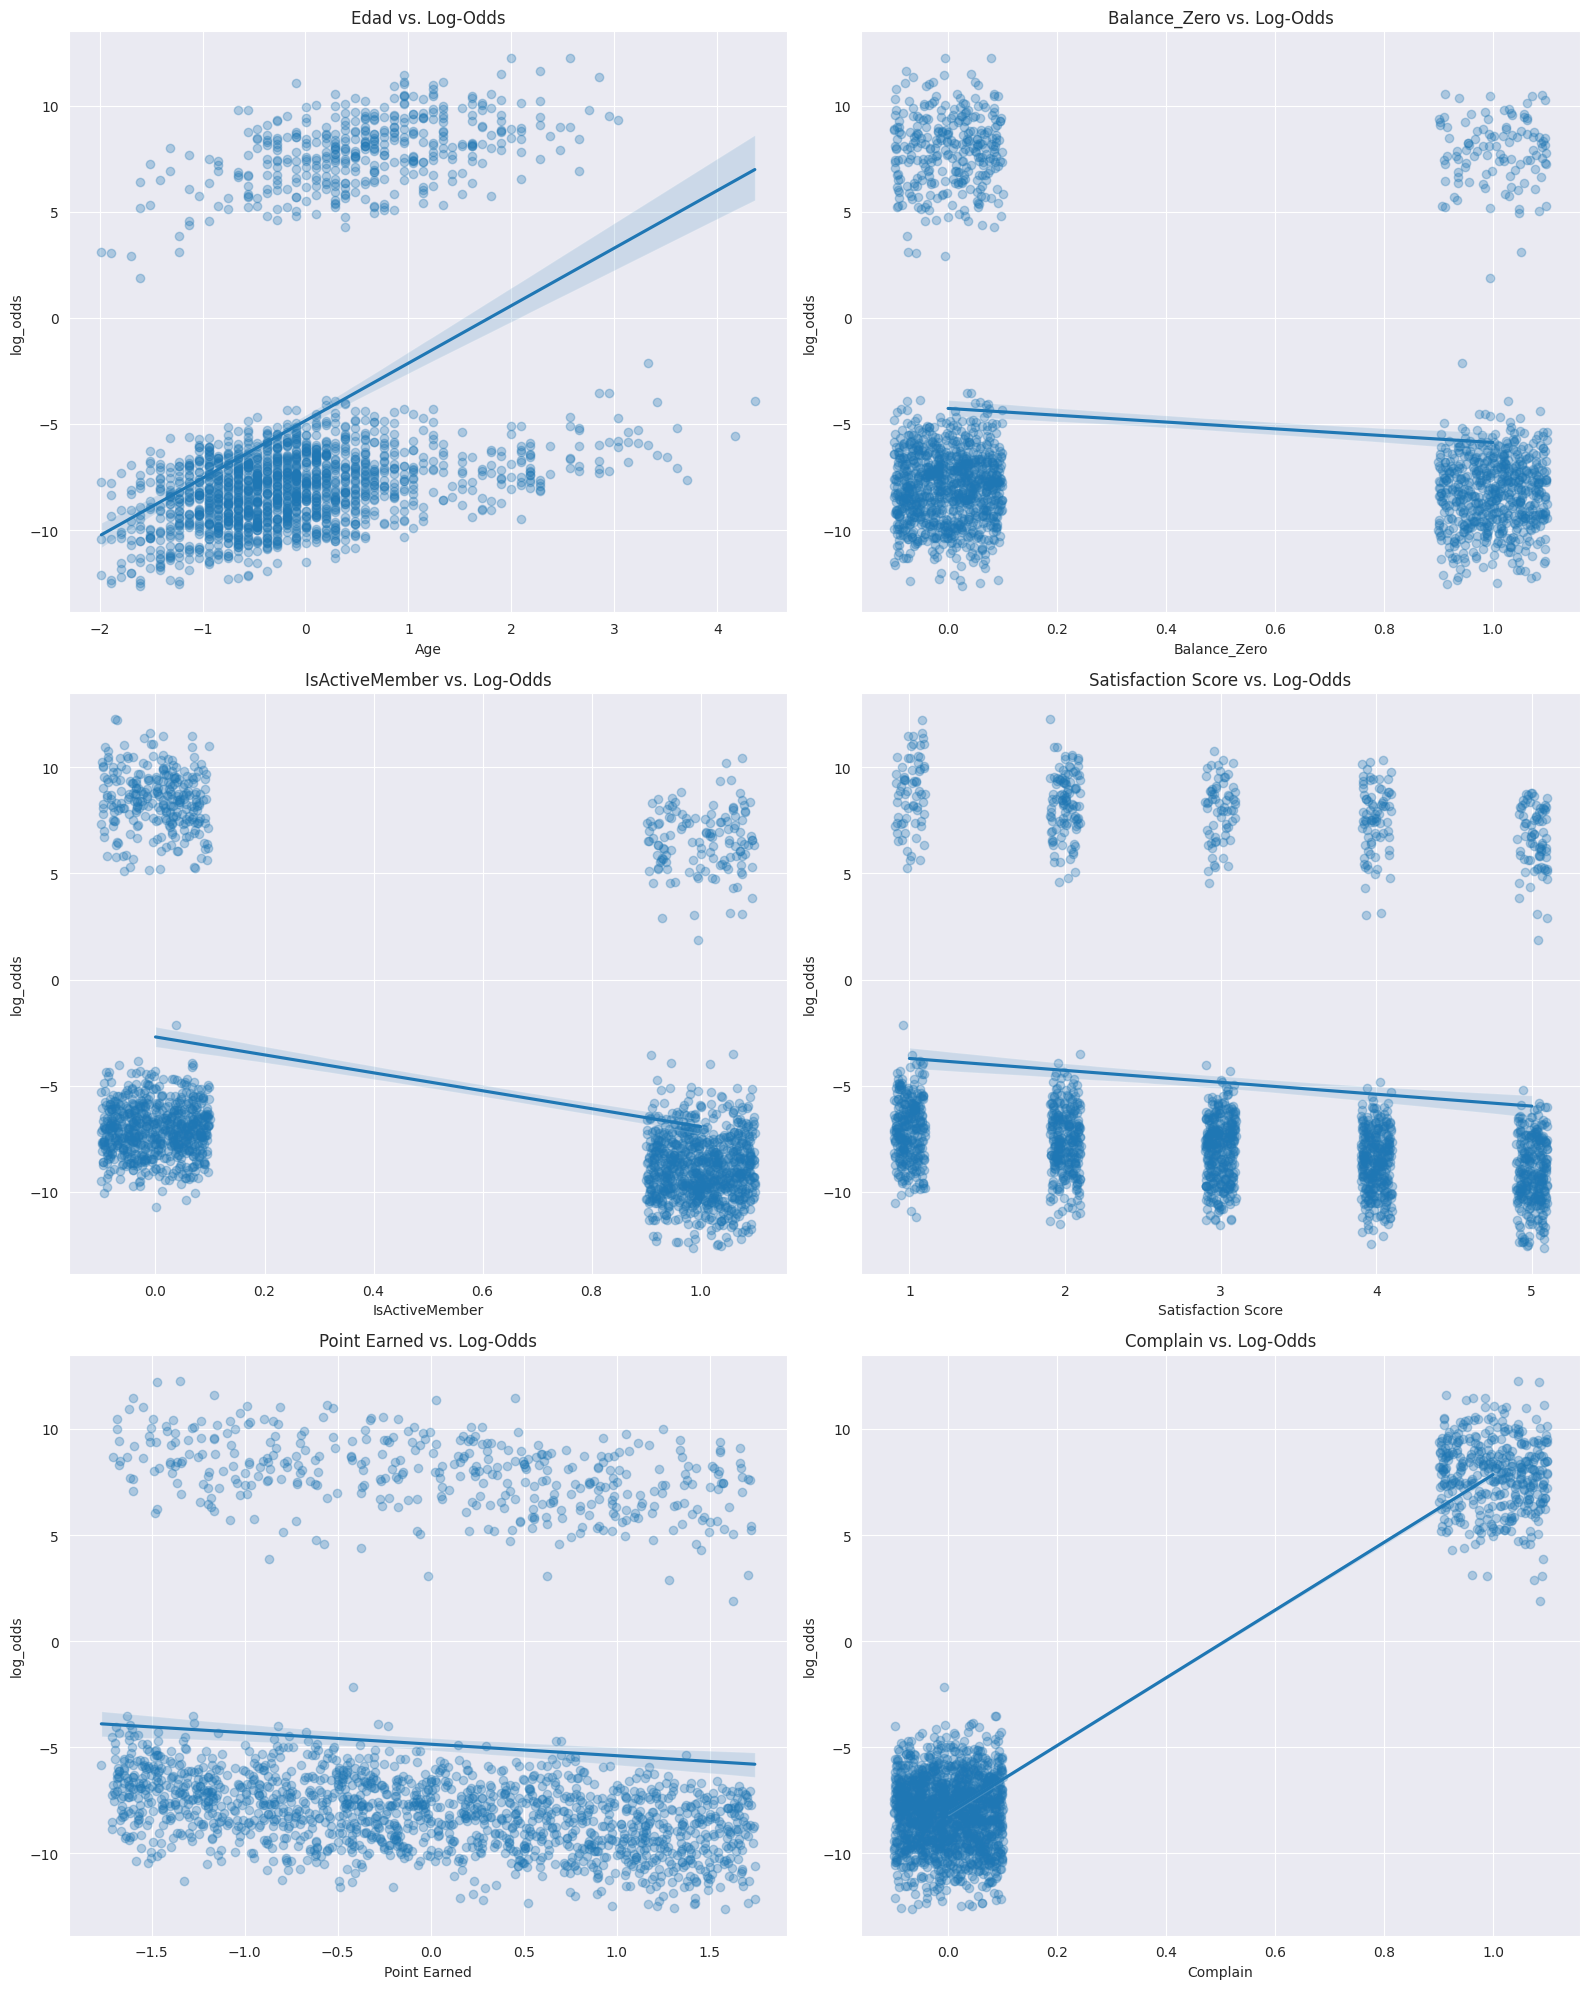

Coeficientes del Modelo (Pesos de las Características):
Complain              14.852604
Age                    0.957147
CreditScore            0.248810
EstimatedSalary        0.185301
Tenure                 0.007357
Balance                0.000000
Geography_France       0.000000
Card Type_GOLD         0.000000
Gender_Male            0.000000
Card Type_SILVER       0.000000
HasCrCard              0.000000
Card Type_DIAMOND     -0.032322
Geography_Spain       -0.056656
NumOfProducts         -0.192615
Card Type_PLATINUM    -0.256248
Balance_Zero          -0.256739
Geography_Germany     -0.261908
Gender_Female         -0.424788
Satisfaction Score    -0.486534
Point Earned          -0.744587
IsActiveMember        -2.078437
dtype: float64


In [ ]:

# 1. Transformar los datos de prueba usando el preprocesador del pipeline
preprocessor = best_model_LR.named_steps['preprocessor']
X_test_transformed = preprocessor.transform(X_test)

# 2. Obtener el logaritmo de las probabilidades usando el método decision_function
classifier = best_model_LR.named_steps['classifier']
log_odds = classifier.decision_function(X_test_transformed)

# 3. Crear un DataFrame para los gráficos
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
new_column_names = numerical_features + list(ohe_feature_names) + passthrough_features

df_analysis = pd.DataFrame(X_test_transformed, columns=new_column_names)
df_analysis['log_odds'] = log_odds
df_analysis['Exited'] = y_test.values

# 4. Crear gráficos de dispersión para las características clave
fig, axes = plt.subplots(3, 2, figsize=(16, 20)) # 3 filas, 2 columnas para 6 gráficos

# Fila 1
sns.regplot(x='Age', y='log_odds', data=df_analysis, ax=axes[0, 0], scatter_kws={'alpha':0.3})
axes[0, 0].set_title('Edad vs. Log-Odds')

sns.regplot(x='Balance_Zero', y='log_odds', data=df_analysis, ax=axes[0, 1], x_jitter=.1, scatter_kws={'alpha':0.3})
axes[0, 1].set_title('Balance_Zero vs. Log-Odds')

# Fila 2
sns.regplot(x='IsActiveMember', y='log_odds', data=df_analysis, ax=axes[1, 0], x_jitter=.1, scatter_kws={'alpha':0.3})
axes[1, 0].set_title('IsActiveMember vs. Log-Odds')

sns.regplot(x='Satisfaction Score', y='log_odds', data=df_analysis, ax=axes[1, 1], x_jitter=.1, scatter_kws={'alpha':0.3})
axes[1, 1].set_title('Satisfaction Score vs. Log-Odds')

# Fila 3
sns.regplot(x='Point Earned', y='log_odds', data=df_analysis, ax=axes[2, 0], scatter_kws={'alpha':0.3})
axes[2, 0].set_title('Point Earned vs. Log-Odds')

sns.regplot(x='Complain', y='log_odds', data=df_analysis, ax=axes[2, 1], x_jitter=.1, scatter_kws={'alpha':0.3})
axes[2, 1].set_title('Complain vs. Log-Odds')

plt.tight_layout()
plt.show()

# 5. También puedes analizar los coeficientes para entender la relación lineal
coefficients = pd.Series(classifier.coef_[0], index=new_column_names).sort_values(ascending=False)
print("Coeficientes del Modelo (Pesos de las Características):")
print(coefficients)

**Conclusiones del EDA Validadas por los pesos del Modelo**

El modelo de regresión logística confirmó que las variables que se identificaron en el **EDA** son las más importantes para predecir el abandono de clientes. Esto permite afirmar con confianza que los hallazgos iniciales **son robustos** y están respaldados por un modelo estadístico avanzado.

- **Variables clave**: Las variables **Complain** (14.85), **Age** (0.95) e **IsActiveMember** (-2.07) mostraron pesos significativos. Su alta contribución en el modelo valida la intuición inicial.

- **Importancia del Género , Geography y NumOfProducts**: El modelo confirmó que el género es un predictor, con un peso considerable para **Gender_Female (-0.43)**, sugiriendo que, en igualdad de condiciones, las mujeres tienen una menor probabilidad de abandonar.
Por su parte, la geografía tuvo un peso considerable para el país Alemán **(Geogaphy_Germany:-0.26)** mientras que haber comprado más productos con el banco disminuye el abandono **(Num of Product: -0.19)**

- **Has Card**: Se busca notar que la variable cumple la hipótesis sugerida por la prueba de Cramér's.

- A su vez, si bien **Balance** no presenta un peso considerable , la creación de **Balance_zero:-0.25** fue muy importante.

**Se puede apreciar que la ausencia de Geography en SHAPE Values muestra como dicha prueba evalua la importancia relativa al problema de clasificación**


**Hallazgos Adicionales Descubiertos por el Modelo - Verificado mediante SHAPE Values**

El modelo de regresión logística aportó un valor adicional al proyecto, encontrando variables predictoras importantes en su contexto multvariado.

- **Satisfaction Score (-0.48)**: Aunque no se encontró una correlación fuerte en el EDA, el modelo descubrió que la satisfacción es un factor clave cuando se considera junto con las otras variables.

- **Point Earned (-0.74) - Credit Score (0.25) - Estimated Salary (0.185)**: Similarmente, los puntos de lealtad resultaron ser un factor de retención muy relevante en el modelo. A su vez, el puntaje Crediticio y el salario contribuyeron positivamente al abandono.

- **Balance_Zero (-0.25)**: Esta variable, fruto de la ingeniería de características, se convirtió en un predictor valioso, demostrando que tener un saldo cero es más importante para la predicción que el valor exacto del saldo.

**Verificación de la Linealidad del problema**


Para confirmar la **naturaleza lineal** de las relaciones que el modelo de regresión logística ha identificado, se comparan los pesos **(coeficientes)** asignados por el modelo a cada característica con el **coeficiente de correlación de Pearson** entre las features y el logaritmo de las probabilidades **(log-odds)**. Una fuerte concordancia entre ambas medidas refuerza la validez de la suposición de linealidad.

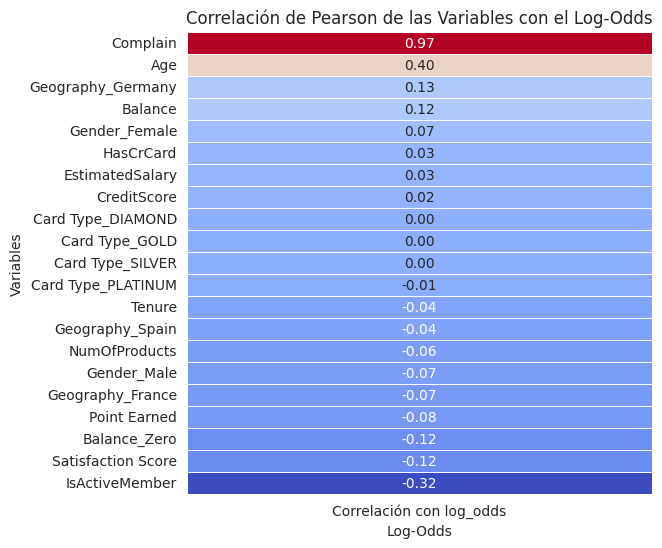

In [ ]:


# Paso 1: Eliminar la columna 'Exited' del DataFrame de análisis
df_corr_analysis = df_analysis.drop(columns=['Exited'])

# Paso 2: Calcular la correlación de Pearson de todas las columnas con 'log_odds'
correlations_log_odds = df_corr_analysis.corr()['log_odds'].sort_values(ascending=False)

# Paso 3: Eliminar la correlación de 'log_odds' consigo mismo para una mejor visualización
correlations_log_odds = correlations_log_odds.drop('log_odds')

# Paso 4: Convertir la Serie a un DataFrame para el heatmap
df_corr = correlations_log_odds.to_frame(name='Correlación con log_odds')

# Paso 5: Visualizar la matriz de correlación en un heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=False)
plt.title('Correlación de Pearson de las Variables con el Log-Odds')
plt.xlabel('Log-Odds')
plt.ylabel('Variables')
plt.show()

**Análisis Comparativo de los pesos y la relación lineal con el log-odds**

Observamos una clara alineación entre los coeficientes del modelo y la correlación de Pearson con el log-odds para las variables más influyentes:

**Complain:**

**Coeficiente del Modelo:** 14.84 (peso extremadamente alto y positivo).

**Correlación con Log-Odds:** 0.97 (correlación casi perfecta y positiva).

Esta variable presenta la **relación lineal** más fuerte y directa con el log-odds de abandono. El modelo le asigna un peso dominante, confirmando su rol crítico determinado en el **EDA**

**IsActiveMember:**

**Coeficiente del Modelo:** -2.07 (peso muy alto y negativo).

**Correlación con Log-Odds:** -0.32 (correlación negativa significativa).

Ser un miembro activo reduce drásticamente el log-odds de abandono, con una clara relación lineal inversa y siendo válida la capacidad predictiva sugerida por el **EDA**

**Age:**

**Coeficiente del Modelo:** 0.95 (peso alto y positivo).

**Correlación con Log-Odds:** 0.40 (correlación positiva moderada).

La edad incrementa el log-odds de abandono con una relación lineal sólida, validando la tendencia observada en el **EDA**

**Satisfaction Score:**

**Coeficiente del Modelo:** -0.48 (peso negativo).

**Correlación con Log-Odds:** -0.12 (correlación negativa).

El modelo le otorga un peso significativo a esta variable, indicando una relación lineal inversa con el log-odds de abandono que no sería tan clara con solo la correlación. También se observa la capacidad de **análisis multivariado** del modelo, ya que este no había sido un hallazgo del **EDA**


**Point Earned:**

**Coeficiente del Modelo:** -0.74 (peso alto y negativo).

**Correlación con Log-Odds:**  -0.08 (correlación negativa, pero relativamente baja).

A pesar de una correlación de Pearson aparentemente débil a nivel **bivariado** con el abandono, el modelo asigna un peso considerable a esta variable. Esto sugiere que su verdadero impacto lineal se manifiesta de manera más pronunciada dentro del contexto **multivariado**, donde su efecto se distingue al controlar otras variables. Este es un ejemplo clave de cómo el modelo revela dependencias no evidentes en un análisis superficial del **EDA**.

**Gender_Female:**

**Coeficiente del Modelo:** -0.43 (peso negativo).

**Correlación con Log-Odds:** 0.07 (correlación positiva).

Mediante esta variable se puede explicar porque el hallazgo del **EDA** en el contexto **bivariado** sugiere que las mujeres tienden a abandonar, mientras que en el contexto **multivariado**, tienden a quedarse

**Geography_Germany:**

**Coeficiente del Modelo:** -0.26 (peso negativo).

**Correlación con Log-Odds:** 0.13 (correlación positiva).

Los clientes en Alemania tienen una relación lineal inversa con el log-odds de abandono, lo que sugiere que su ubicación es un factor de retención. Si bien fue considerada variable predictora en el **EDA**, el **SHAPE Values** demostró que no guardaba importancia relativa con el abandono en este contexto **multivariado**. A su vez, de acuerdo al bar plot del **EDA** se había pensado que Alemania era un país infiel, lo que no parece ser decretado por el modelo.

**Credit Score:**

**Coeficiente del Modelo:** 0,25 (peso positivo).

**Correlación con Log-Odds:** 0.02 (correlación positiva).

Los clientes con alto score crediticio tienden a abandonar. Este comportamiento se puede deducir en el **(SHAPE Values)** y no fue determinado en el **EDA**

**Estimated Salary:**

**Coeficiente del Modelo:** 0,184 (peso positivo).

**Correlación con Log-Odds:** 0.03 (correlación positiva).

Los cientes con alto salario tienden a abandonar.Este comportamiento se puede deducir en el **(SHAPE Values)** y no fue determinado en el **EDA**

**Balance_Zero:**

**Coeficiente del Modelo:** -0.25 (peso negativo).

**Correlación con Log-Odds:** -0.12 (correlación negativa).

Esta variable, resultado de la ingeniería de las características, demuestra una clara relación lineal con el log-odds. El modelo confirma que tener un saldo cero tiene un impacto negativo en la probabilidad de abandono, lo que es un hallazgo clave del **EDA**

**NumOfProducts:**

**Coeficiente del Modelo:** -0.18 (peso negativo).

**Correlación con Log-Odds:** -0.06 (correlación negativa).

El modelo le asigna un peso que confirma la relación lineal inversa: a más productos que un cliente tiene, menor es la probabilidad de que abandone. Esta relación con el abandono fue otro hallazgo del **EDA**



## **Conclusión de la sección**

La comparación de modelos permitió observar dos patrones claros:

**Modelos de árboles (XGBoost, Random Forest, LightGBM):** Se apoyan casi exclusivamente en la variable **Complain**, con muy poco aporte del resto de las características. Esto los hace menos robustos, ya que dependen de una sola fuente de información.

**Regresión Logística:** Reparte los pesos de manera más balanceada, asignando importancia a variables adicionales como **Age, IsActiveMember, NumOfProducts, Satisfaction Score , Point Earned** entre otras.



#  **7.Conclusiones**

El análisis exploratorio de datos **(EDA)** permitió identificar variables claves relacionadas con el abandono de clientes, destacándose **Complain, Age, IsActiveMember, Balance, NumOfProducts, Gender y Geography** como los principales factores explicativos. Estos hallazgos iniciales fueron posteriormente confirmados y enriquecidos mediante el modelado predictivo.

Al comparar distintos **algoritmos** de clasificación, se observó que todos alcanzaron un desempeño muy elevado en términos de **AUC-ROC** (superior al 0.96 en todos los casos). El modelo con mayor valor de AUC fue **XGBoost (0.9995**), seguido muy de cerca por Regresión Logística **(0.9988)**, **Random Forest (0.9983)** y **LightGBM (0.9980)**. El modelo **KNN (0.9698)**, aunque con un AUC más bajo, también logró un rendimiento aceptable.

Sin embargo, más allá del desempeño numérico, el análisis con **SHAP values** y los **coeficientes de la regresión logística** mostraron diferencias clave en la forma en que los modelos toman sus decisiones. Los modelos de árboles **(XGBoost, LightGBM y Random Forest)** dependieron de manera casi exclusiva de la variable **Complain**, lo cual, si bien ofrece una gran capacidad predictiva, genera un riesgo de sobredependencia: si esta variable no estuviera disponible en el futuro, el rendimiento podría deteriorarse significativamente.

En contraste, la **Regresión Logística** distribuyó de manera más equilibrada la importancia entre múltiples variables **(Age, IsActiveMember, NumOfProducts, Point Earned, Satisfaction Score, Balance_Zero, entre otras)**. Esta característica la convierte en un modelo más **simple, interpretable y robusto ante cambios futuros**, ya que no se apoya en un único predictor. Además, su estructura estadística permitió **validar** la linealidad entre los predictores y el log-odds, confirmando los hallazgos del **EDA** con una base matemática sólida.

Por lo tanto, aunque modelos como **XGBoost** ofrecen un rendimiento ligeramente superior en métricas, se concluye que la **Regresión Logística** es la mejor opción para este caso de negocio, al combinar alto desempeño, interpretabilidad y robustez al cambio.